In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import os
import random

import matplotlib
import matplotlib.font_manager as fm

matplotlib.rcParams['font.size'] = 8
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
fm.FontProperties().set_family('arial')

%load_ext autoreload
%autoreload 2
%matplotlib inline
# %matplotlib widget
# %matplotlib notebook

In [2]:
#all a single example session

results_paths={}

# results_paths['context']="s3://aind-scratch-data/dynamic-routing/decoding/results/test_0.05s_multi_timebin_0/"
# results_paths['context_baseline_subtract'] = "s3://aind-scratch-data/dynamic-routing/decoding/results/test_baseline_subtracted_0/"
# results_paths['response'] = "s3://aind-scratch-data/dynamic-routing/decoding/results/test_decoding_licks_0/"
# results_paths['response_baseline_subtract'] = "s3://aind-scratch-data/dynamic-routing/decoding/results/test_decoding_licks_baseline_subtracted_1/"

# results_paths['context_baseline_subtract_vis1_only'] = "s3://aind-scratch-data/dynamic-routing/decoding/results/test_baseline_subtract_vis1_only_0/"
# results_paths['context_baseline_subtract_sound1_only'] = "s3://aind-scratch-data/dynamic-routing/decoding/results/test_baseline_subtract_sound1_only_0/"

# results_paths['response_baseline_subtract_vis1_only'] = "s3://aind-scratch-data/dynamic-routing/decoding/results/test_decode_licks_vis1_only_baseline_subtract_20250827_174517/"
# results_paths['response_baseline_subtract_sound1_only'] = "s3://aind-scratch-data/dynamic-routing/decoding/results/test_decode_licks_sound1_only_baseline_subtract_20250827_174716/"

# results_paths['response_baseline_subtract_unrewarded_target'] = "s3://aind-scratch-data/dynamic-routing/decoding/results/test_decode_licks_unrewarded_target_baseline_subtract_20250827_224845/"

# results_paths['response_baseline_subtract_sound1_vis_context'] = "s3://aind-scratch-data/dynamic-routing/decoding/results/test_decode_licks_sound1_in_vis_context_baseline_subtract_20250827_223700/"

# results_paths['context_baseline_subtract_cumulative_0.01'] ="s3://aind-scratch-data/dynamic-routing/decoding/results/test_cumulative_baseline_subtract_all_units_20250829_181812/"
# results_paths['context_baseline_subtract_cumulative_0.02'] = "s3://aind-scratch-data/dynamic-routing/decoding/results/test_cumulative_baseline_subtract_all_units_20250829_185213/"
# results_paths['context_baseline_subtract_cumulative_0.05'] = "s3://aind-scratch-data/dynamic-routing/decoding/results/test_cumulative_baseline_subtract_all_units_20250829_193324/"
# results_paths['context_cumulative_0.05'] = "s3://aind-scratch-data/dynamic-routing/decoding/results/test_cumulative_all_units_20250829_194357/"



# #baseline subtracted, sliding window

# results_paths['context_all_trials_no_baseline_subtract'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_context_10ms_no_baseline_subtract_0/"
# results_paths['context_all_trials'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/baseline_subtract_10ms_step_50ms_window_0/"
# #cumulative decoding
# results_paths['context_cumulative']=r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_context_baseline_subtract_cumulative_10ms_0/"
# #decoding with only vis/aud target trials
# results_paths['context_aud_target'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/baseline_subtract_10ms_step_50ms_window_aud_target_0/"
# results_paths['context_vis_target'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/baseline_subtract_10ms_step_50ms_window_vis_target_0/"

# results_paths['response_all_trials_no_baseline_subtract'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_response_no_baseline_subtract_0/"
# results_paths['response_all_trials'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/baseline_subtract_10ms_step_50ms_window_decode_response_0/"
# results_paths['response_aud_target'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/baseline_subtract_10ms_step_50ms_window_decode_response_aud_target_0/"
# results_paths['response_vis_target'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/baseline_subtract_10ms_step_50ms_window_decode_response_vis_target_0/"

# #baseline subtracted, decode stimulus in different contexts
# results_paths['aud_stim_all_blocks'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_aud_stim_all_blocks_0/"
# results_paths['aud_stim_all_blocks_baseline_subtract'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_aud_stim_all_blocks_baseline_subtract_0/"
# results_paths['aud_stim_in_aud_context'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_aud_stim_aud_block_baseline_subtract_0/"
# results_paths['aud_stim_in_vis_context'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_aud_stim_vis_block_baseline_subtract_0/"
# results_paths['aud_stim_in_vis_context_CR'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_aud_stim_vis_block_CR_baseline_subtract_0/"
# results_paths['aud_stim_in_vis_context_FA'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_aud_stim_vis_block_FA_baseline_subtract_0/"

# results_paths['vis_stim_all_blocks'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_vis_stim_all_blocks_0/"
# results_paths['vis_stim_all_blocks_baseline_subtract'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_vis_stim_all_blocks_baseline_subtract_0/"
# results_paths['vis_stim_in_aud_context'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_vis_stim_aud_block_baseline_subtract_0/"
# results_paths['vis_stim_in_vis_context'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_vis_stim_vis_block_baseline_subtract_0/"
# results_paths['vis_stim_in_aud_context_CR'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_vis_stim_aud_block_CR_baseline_subtract_0/"
# results_paths['vis_stim_in_aud_context_FA'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_vis_stim_aud_block_FA_baseline_subtract_0/"

# results_paths['vis_appropriate_response'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_vis_appropriate_response_baseline_subtract_10ms_20250917_174540/"


# #10unit minimum results:
# results_paths['context_all_trials_no_baseline_subtract_10units'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_context_10ms_bins_10_units_0/"
# results_paths['context_all_trials_baseline_subtract_10units'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_context_baseline_subtract_10ms_bins_10_units_0/"

# results_paths['response_all_trials_10units'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_response_10ms_bins_10_units_0/"

# results_paths['vis_stim_all_blocks_10units'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_vis_stim_all_blocks_10ms_bins_10_units_0/"
# results_paths['aud_stim_all_blocks_10units'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_aud_stim_all_blocks_10ms_bins_10_units_0/"


# #only aud or vis trials:
# results_paths['context_baseline_subtract_aud_stim_10units'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_context_baseline_subtract_aud_stim_10ms_bins_10_units_0/"
# results_paths['context_no_baseline_subtract_aud_stim_10units'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_context_no_baseline_subtract_aud_stim_10ms_bins_10_units_0/"
# results_paths['context_baseline_subtract_vis_stim_10units'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_context_baseline_subtract_vis_stim_10ms_bins_10_units_0/"
# results_paths['context_no_baseline_subtract_vis_stim_10units'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_context_no_baseline_subtract_vis_stim_10ms_bins_10_units_0/"

# results_paths['response_aud_stim_10units'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_response_aud_stim_10ms_bins_10_units_0/"
# results_paths['response_baseline_subtract_aud_stim_10units'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_response_baseline_subtract_aud_stim_10ms_bins_10_units_0/"
# results_paths['response_vis_stim_10units'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_response_vis_stim_10ms_bins_10_units_0/"
# results_paths['response_baseline_subtract_vis_stim_10units'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_response_baseline_subtract_vis_stim_10ms_bins_10_units_0/"

# results_paths['aud_stim_all_blocks_10units'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_aud_stim_all_blocks_10ms_bins_10_units_0/"
# results_paths['vis_stim_all_blocks_10units'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_vis_stim_all_blocks_10ms_bins_10_units_0/"


# #align to response
# results_paths['response_aligned_decode_context_targets_only'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/response_aligned_decode_context_targets_25ms_0/"
# results_paths['response_aligned_decode_reward_targets_only'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/response_aligned_decode_reward_targets_25ms_0/"


#single stimulus, 5ms bins
results_paths['decode_context_baseline_subtract_vis_target_all_trials_5ms_bin_25ms_window'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_context_baseline_subtract_vis_target_all_trials_5ms_bin_25ms_window_0/"
results_paths['decode_context_baseline_subtract_vis_target_correct_trials_5ms_bin_25ms_window'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_context_baseline_subtract_vis_target_correct_trials_5ms_bin_25ms_window_0/"

In [3]:
session_table_path=r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\session_table_v0.272.csv"
# session_table_path="/Users/ethan.mcbride/Data/DR/session_table_v0.265.csv"
session_table=pl.read_csv(session_table_path)

dr_session_list=(
    session_table.filter(
    pl.col('project')=="DynamicRouting",
    pl.col('is_production'),
    pl.col('is_annotated'),
    pl.col('issues')=="",
    pl.col('is_engaged'),
    pl.col('is_good_behavior').eq(True),
    )['session_id'].to_list()
    )

In [4]:
#define grouping columns
grouping_cols = {
    'session_id',
    'structure',
    'electrode_group_names',
    'unit_subsample_size',
    'bin_center',
    'bin_size',
    'time_aligned_to',
    # 'unit_criteria',
}

#toggle keep_original_structure
keep_original_structure = False
if keep_original_structure:
    n_repeats = 2
else:
    n_repeats = 1

#toggle combine_multi_probe_rec
combine_multi_probe_rec = True

if combine_multi_probe_rec:
    combine_multi_probe_expr = pl.col('electrode_group_names').list.len().gt(1) | pl.col('is_sole_recording').eq(True)
else:
    combine_multi_probe_expr = pl.col('electrode_group_names').list.len().eq(1) | pl.col('is_sole_recording').eq(True)

# map structures to grouped structures
# SCop, SCsg, SCzo -> SCs
# SCig, SCiw, SCdg, SCdw -> SCm
# ECT1, ECT2/3, ECT6b, ECT5, ECT6a, ECT4 -> ECT
structure_grouping = {
    'SCop': 'SCs',
    'SCsg': 'SCs',
    'SCzo': 'SCs',
    'SCig': 'SCm',
    'SCiw': 'SCm',
    'SCdg': 'SCm',
    'SCdw': 'SCm',
    "ECT1": 'ECT',
    "ECT2/3": 'ECT',    
    "ECT6b": 'ECT',
    "ECT5": 'ECT',
    "ECT6a": 'ECT', 
    "ECT4": 'ECT',
}



In [5]:
# session-wise average decoding accuracy

def get_results_df(results_path, dr_session_list, session_table, grouping_cols, combine_multi_probe_expr, n_repeats, structure_grouping):

    new_results_session_df = (
        pl.scan_parquet(results_path)
        .filter(
            pl.col('session_id').is_in(dr_session_list),
        )
        .with_columns(
            pl.col('electrode_group_names').flatten().n_unique().eq(1).over(grouping_cols - {'electrode_group_names'}).alias('is_sole_recording'),
        )
        .filter(
            combine_multi_probe_expr,
            pl.col('is_all_trials').not_(),
        )
        #get total n units
        .join(
            other=(
                pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.272/consolidated/units.parquet')
                .with_columns(
                    pl.col('session_id').str.split('_').list.slice(0, 2).list.join('_'),
                )
                #make new rows according to structure_grouping
                .with_columns(
                    pl.when(pl.col('structure').is_in(structure_grouping.keys()))
                    .then(pl.col('structure').repeat_by(n_repeats))
                    .otherwise(pl.col('structure').repeat_by(1))
                )
                .explode('structure')
                .with_columns(
                    pl.when(pl.col('structure').is_in(structure_grouping.keys()).is_first_distinct().over('unit_id'))
                    .then(pl.col('structure').replace(structure_grouping))
                    .otherwise(pl.col('structure'))
                )
                .group_by('session_id','structure')
                .agg(
                    pl.col('unit_id').len().alias('total_n_units')
                )
            ),
            on=['session_id','structure'],
            how='left',
        )
        #join on session table to get cross-modal dprime, etc.
        .join(
            other=session_table.filter(
                pl.col('session_id').is_in(dr_session_list)
            ).select(
                'session_id',
                'n_passing_blocks',
                'cross_modality_dprime_vis_blocks',
                'cross_modality_dprime_aud_blocks',
            ).lazy(),
            on='session_id',
            how='left',
        )
        # get the means for each recording over repeats:
        .group_by(grouping_cols | {'shift_idx', 'n_passing_blocks', 'cross_modality_dprime_vis_blocks', 
                                'cross_modality_dprime_aud_blocks', 'total_n_units'}, maintain_order=True)
        .agg(
            pl.col('balanced_accuracy_test').mean(), # over repeats
        )
        # get the aligned result and median over shifts:
        .group_by(grouping_cols - {'electrode_group_names'} | {'n_passing_blocks', 'cross_modality_dprime_vis_blocks', 
                                                            'cross_modality_dprime_aud_blocks', 'total_n_units'})
        .agg(
            pl.col('balanced_accuracy_test').filter(pl.col('shift_idx') == 0).first().alias('mean_true'),
            pl.col('balanced_accuracy_test').filter(pl.col('shift_idx') != 0).median().alias('median_null'),
            pl.col('balanced_accuracy_test', 'shift_idx').sort_by('shift_idx'),
        )
        # get the difference between true and null:
        .with_columns(
            pl.col('mean_true').sub(pl.col('median_null')).alias('mean_diff'),
        )
        .sort('structure', 'unit_subsample_size', descending=False)
        .collect()
    )

    return new_results_session_df.to_pandas()

In [6]:
results_dfs={}
for key, results_path in results_paths.items():
    print(f"Loading results from {key}...")
    results_dfs[key] = get_results_df(results_path, dr_session_list, session_table, grouping_cols, combine_multi_probe_expr, n_repeats, structure_grouping)

Loading results from decode_context_baseline_subtract_vis_target_all_trials_5ms_bin_25ms_window...
Loading results from decode_context_baseline_subtract_vis_target_correct_trials_5ms_bin_25ms_window...


In [7]:
# save individual dfs from resuts_dfs as parquet files
savepath = r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\baseline_subtract_decoding_summary_tables-2025-09-11"

for key, df in results_dfs.items():
    df.to_parquet(os.path.join(savepath, f"{key}_decoding_summary_table.parquet"))



In [ ]:
#load results from parquet files
savepath = r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\baseline_subtract_decoding_summary_tables-2025-09-11"
results_dfs={}
for filename in os.listdir(savepath):
    if filename.endswith("_decoding_summary_table.parquet"):
        key = filename.replace("_decoding_summary_table.parquet", "")
        df = pd.read_parquet(os.path.join(savepath, filename))
        results_dfs[key] = df

In [ ]:
results_dfs.keys()

In [9]:
savepath=r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\baseline_subtract_vs_not_comps_2025_09_29"

sel_bin_center=0.075
results_dfs['context_all_trials']['bin_center']=results_dfs['context_all_trials']['bin_center'].round(3)
baseline_subtract_context_decoding_summary = results_dfs['context_all_trials'].query(
    'bin_center==@sel_bin_center and n_passing_blocks>=4 and total_n_units>=10').groupby('structure').agg(
    {'mean_true': ['mean', 'sem', 'count']}).sort_values(by='structure')
baseline_subtract_context_decoding_summary.columns = ['_'.join(col).strip() for col in baseline_subtract_context_decoding_summary.columns.values]
baseline_subtract_context_decoding_summary.to_csv(os.path.join(savepath, 'baseline_subtract_context_decoding_summary.csv'))

sel_bin_center=-0.075
baseline_subtract_prestim_context_decoding_summary = results_dfs['context_all_trials'].query(
    'bin_center==@sel_bin_center and n_passing_blocks>=4 and total_n_units>=10').groupby('structure').agg(
    {'mean_true': ['mean', 'sem', 'count']}).sort_values(by='structure')
baseline_subtract_prestim_context_decoding_summary.columns = ['_'.join(col).strip() for col in baseline_subtract_prestim_context_decoding_summary.columns.values]
baseline_subtract_prestim_context_decoding_summary.to_csv(os.path.join(savepath, 'baseline_subtract_prestim_context_decoding_summary.csv'))


# 'context_all_trials_no_baseline_subtract'
results_dfs['context_all_trials_no_baseline_subtract']['bin_center']=results_dfs['context_all_trials_no_baseline_subtract']['bin_center'].round(3)

sel_bin_center=0.075
no_baseline_subtract_stim_context_decoding_summary = results_dfs['context_all_trials_no_baseline_subtract'].query(
    'bin_center==@sel_bin_center and n_passing_blocks>=4 and total_n_units>=10').groupby('structure').agg(
    {'mean_true': ['mean', 'sem', 'count']}).sort_values(by='structure')
no_baseline_subtract_stim_context_decoding_summary.columns = ['_'.join(col).strip() for col in no_baseline_subtract_stim_context_decoding_summary.columns.values]
no_baseline_subtract_stim_context_decoding_summary.to_csv(os.path.join(savepath, 'no_baseline_subtract_stim_context_decoding_summary.csv'))

sel_bin_center=-0.075
no_baseline_subtract_prestim_context_decoding_summary = results_dfs['context_all_trials_no_baseline_subtract'].query(
    'bin_center==@sel_bin_center and n_passing_blocks>=4 and total_n_units>=10').groupby('structure').agg(
    {'mean_true': ['mean', 'sem', 'count']}).sort_values(by='structure')
no_baseline_subtract_prestim_context_decoding_summary.columns = ['_'.join(col).strip() for col in no_baseline_subtract_prestim_context_decoding_summary.columns.values]
no_baseline_subtract_prestim_context_decoding_summary.to_csv(os.path.join(savepath, 'no_baseline_subtract_prestim_context_decoding_summary.csv'))


KeyError: 'context_all_trials'

NameError: name 'baseline_subtract_context_decoding_summary' is not defined

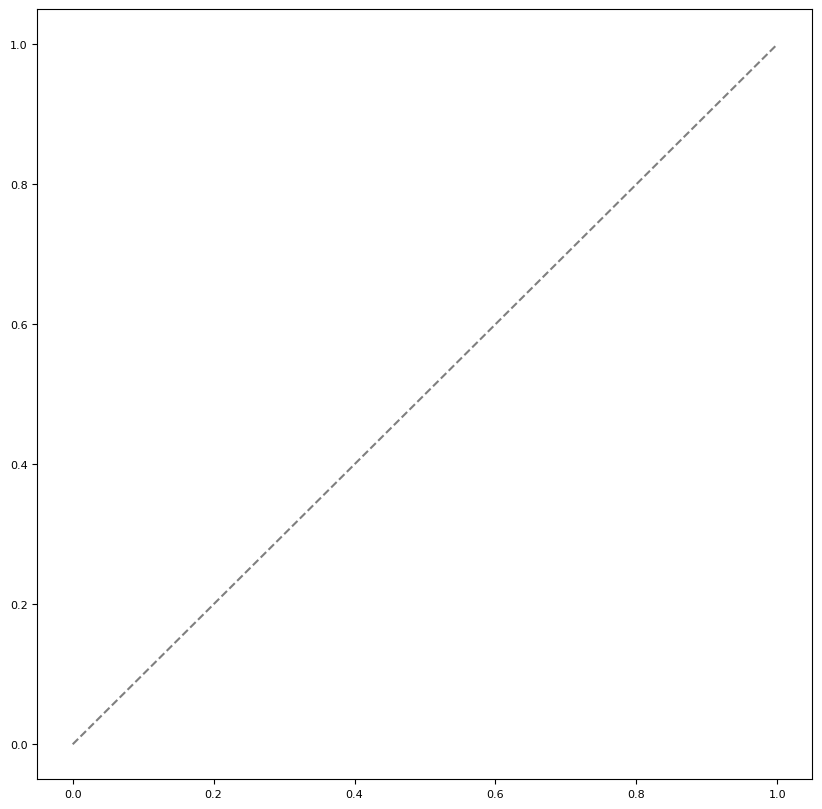

In [8]:
fig,ax=plt.subplots(1,1,figsize=(10,10))
#plot unity line
ax.plot([0,1],[0,1],'k--',alpha=0.5)
ax.plot(baseline_subtract_context_decoding_summary.query('mean_true_count>=3')['mean_true_mean'],
        no_baseline_subtract_prestim_context_decoding_summary.query('mean_true_count>=3')['mean_true_mean'],
        'k.', label='baseline subtract')

# plot structure acronym next to points
for structure in baseline_subtract_context_decoding_summary.query('mean_true_count>=3').index:
    ax.text(baseline_subtract_context_decoding_summary.loc[structure, 'mean_true_mean'],
            no_baseline_subtract_prestim_context_decoding_summary.loc[structure, 'mean_true_mean'],
            structure)

ax.set_xlim(0.5,0.8)
ax.set_ylim(0.5,0.8)


NameError: name 'no_baseline_subtract_stim_context_decoding_summary' is not defined

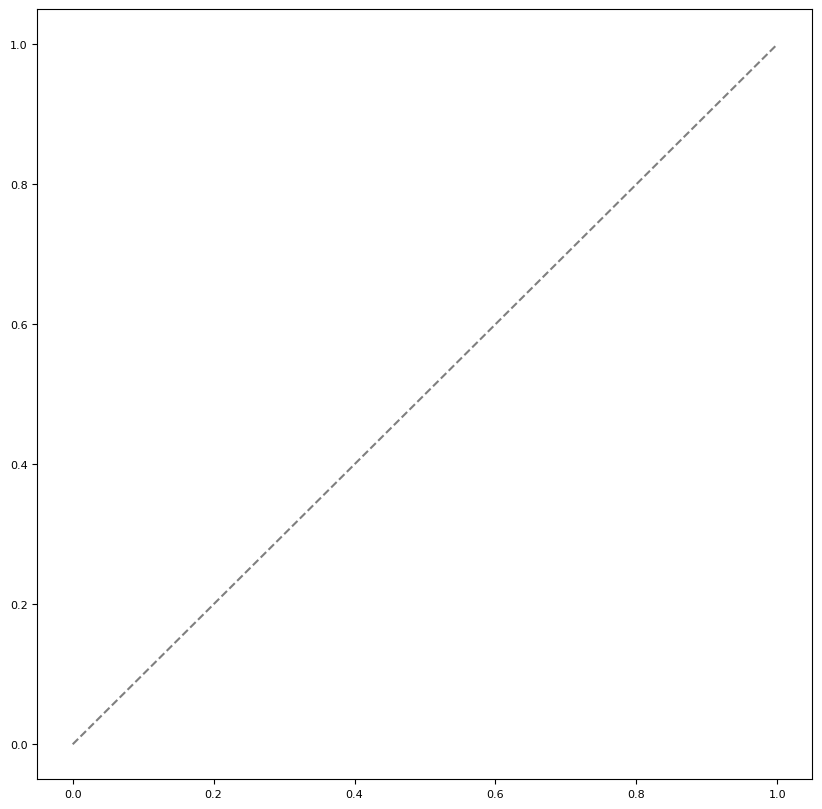

In [8]:
fig,ax=plt.subplots(1,1,figsize=(10,10))
#plot unity line
ax.plot([0,1],[0,1],'k--',alpha=0.5)
ax.plot(no_baseline_subtract_stim_context_decoding_summary.query('mean_true_count>=3')['mean_true_mean'],
        no_baseline_subtract_prestim_context_decoding_summary.query('mean_true_count>=3')['mean_true_mean'],
        'k.', label='no baseline subtract')

# plot structure acronym next to points
for structure in no_baseline_subtract_stim_context_decoding_summary.query('mean_true_count>=3').index:
    ax.text(no_baseline_subtract_stim_context_decoding_summary.loc[structure, 'mean_true_mean'],
            no_baseline_subtract_prestim_context_decoding_summary.loc[structure, 'mean_true_mean'],
            structure)

ax.set_xlim(0.5,0.8)
ax.set_ylim(0.5,0.8)

In [ ]:
# no_baseline_subtract_prestim_context_decoding_summary.columns = ['_'.join(col).strip() for col in no_baseline_subtract_prestim_context_decoding_summary.columns.values]
fig,ax=plt.subplots(1,1,figsize=(12,3))
baseline_subtract_context_decoding_summary.query('mean_true_count>=3').sort_values('mean_true_mean',ascending=False).plot.bar(y='mean_true_mean', yerr='mean_true_sem', ax=ax)
ax.set_ylim(0.5,0.8)

In [ ]:
np.sort(results_dfs[key]['bin_center'].unique())*2

Plotting results from decode_context_baseline_subtract_vis_target_all_trials_5ms_bin_25ms_window...
Plotting results from decode_context_baseline_subtract_vis_target_correct_trials_5ms_bin_25ms_window...


Text(0.5, 1.0, '664851_2023-11-13; CP; stim_start_time; all units')

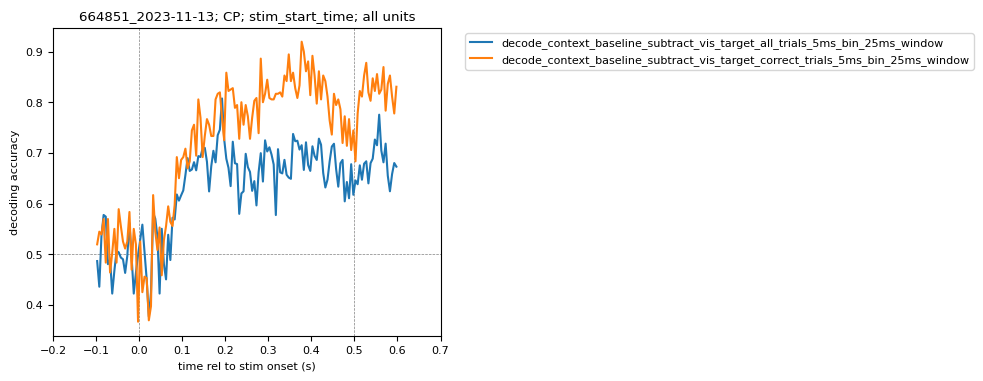

In [11]:

sel_session="664851_2023-11-13"

sel_structure="CP"
sel_unit_subsample_size='all'
sel_time_aligned_to="stim_start_time"
# sel_time_aligned_to="response_time"

# example_timebin_decoding=new_results_session_pd.query('session_id=="664851_2023-11-13" and structure=="ACAd" and \
#                                                     time_aligned_to=="stim_start_time" and unit_subsample_size==20').sort_values('bin_center')

fig,ax=plt.subplots(1,1,figsize=(5,4))
ax.axvline(x=0, color='grey', linestyle='--', linewidth=0.5)
ax.axvline(x=0.5, color='grey', linestyle='--', linewidth=0.5)
ax.axhline(y=0.5, color='grey', linestyle='--', linewidth=0.5)

for key, new_results_session_pd in results_dfs.items():
    print(f"Plotting results from {key}...")

    example_timebin_decoding=new_results_session_pd.query(f'session_id=="{sel_session}" and structure=="{sel_structure}" and \
                                                        time_aligned_to=="{sel_time_aligned_to}" ').sort_values('bin_center')
    # if key=='context_baseline_subtract_cumulative_0.01':
    #     ax.plot((example_timebin_decoding['bin_center']*2+.095).values, example_timebin_decoding['mean_true'], label=key)
    # else:
    ax.plot(example_timebin_decoding['bin_center'], example_timebin_decoding['mean_true'], label=key)

# ax.set_ylim(0.5,1)

ax.set_xlim(-0.2,0.7)
ax.set_xlabel('time rel to stim onset (s)')
ax.set_ylabel('decoding accuracy')
#place legend outside
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# ax.legend()
ax.set_title(f"{sel_session}; {sel_structure}; {sel_time_aligned_to}; {sel_unit_subsample_size} units")

Plotting results from decode_context_baseline_subtract_vis_target_all_trials_5ms_bin_25ms_window...
Plotting results from decode_context_baseline_subtract_vis_target_correct_trials_5ms_bin_25ms_window...


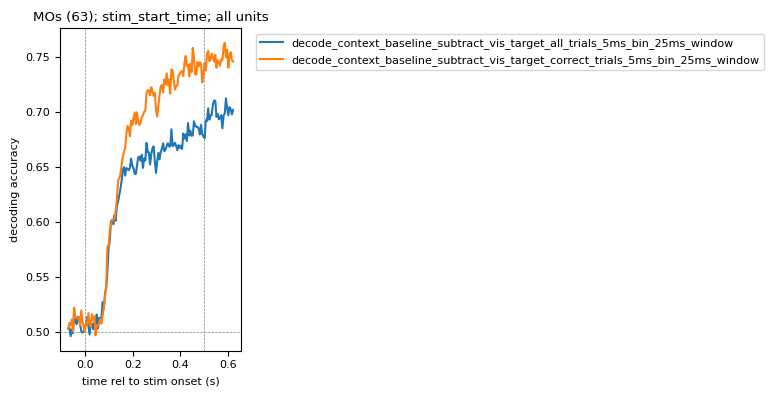

In [13]:
# plot average across sessions by structure

# sel_structure="AId"
sel_unit_subsample_size='all'
# sel_time_aligned_to="response_or_reward_time"
sel_time_aligned_to="stim_start_time"
# time_offset=0.025 #add to bin_centers

# sel_key_set='all_trials'

# key_sets={
#     'all_trials': ['context_all_trials_no_baseline_subtract', 'context_all_trials', 'response_all_trials'],
#     'aud_target': ['context_aud_target', 'response_aud_target', 'aud_stim_in_aud_context', 'aud_stim_in_vis_context'],
#     'vis_target': ['context_vis_target', 'response_vis_target', 'vis_stim_in_aud_context', 'vis_stim_in_vis_context'],
#     'context': ['context_all_trials', 'context_aud_target', 'context_vis_target'],
#     'response': ['response_all_trials', 'response_aud_target', 'response_vis_target'],
#     'cumulative_vs_sliding_window': ['context_all_trials', 'context_cumulative'],
# }

key_sets={
    # 'aud_target_w_CR_FA':['aud_stim_in_aud_context', 'aud_stim_in_vis_context', 'aud_stim_in_vis_context_CR', 'aud_stim_in_vis_context_FA'],
    # 'vis_target_w_CR_FA':['vis_stim_in_aud_context', 'vis_stim_in_vis_context', 'vis_stim_in_aud_context_CR', 'vis_stim_in_aud_context_FA'],
    # 'context_response_vs_appropriate_response':['context_all_trials', 'response_all_trials', 'vis_appropriate_response'],
    # 'all_comps':['context_all_trials_no_baseline_subtract', 'context_all_trials', 
    #              'response_all_trials_no_baseline_subtract', 'response_all_trials', 
    #              'aud_stim_all_blocks', 'aud_stim_all_blocks_baseline_subtract',
    #              'vis_stim_all_blocks', 'vis_stim_all_blocks_baseline_subtract',]
    # '10_unit_minimum':['context_all_trials_no_baseline_subtract_10units', 'context_all_trials_baseline_subtract_10units',
    #                    'response_all_trials_10units',
    #                    'vis_stim_all_blocks_10units', 'aud_stim_all_blocks_10units',
    #                    ]
    # 'aud_stim_only':['context_no_baseline_subtract_aud_stim_10units', 'context_baseline_subtract_aud_stim_10units',
    #                  'response_aud_stim_10units',
    #                  'aud_stim_all_blocks_10units',
    #                  ],
    # 'vis_stim_only':['context_no_baseline_subtract_vis_stim_10units', 'context_baseline_subtract_vis_stim_10units',
    #                  'response_vis_stim_10units',
    #                  'vis_stim_all_blocks_10units',
    #                  ]
    # 'aud_vs_vis_context':['context_no_baseline_subtract_aud_stim_10units', 'context_baseline_subtract_aud_stim_10units',
    #                      'context_no_baseline_subtract_vis_stim_10units', 'context_baseline_subtract_vis_stim_10units',],
    # 'aud_vs_vis_response':['response_aud_stim_10units', 'response_vis_stim_10units',]
    # 'response_aligned_context_vs_reward':['response_aligned_decode_context_targets_only',
    #                                       'response_aligned_decode_reward_targets_only']
    'vis_target_only':['decode_context_baseline_subtract_vis_target_all_trials_5ms_bin_25ms_window',
                       'decode_context_baseline_subtract_vis_target_correct_trials_5ms_bin_25ms_window']
}

savepath=r"C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2025-10-07-decode_split_by_stim_modality\by_area"

for sel_key_set in key_sets.keys():

    for sel_structure in results_dfs[key]['structure'].unique():
        sel_structure='MOs'

        fig,ax=plt.subplots(1,1,figsize=(8,4))
        ax.axvline(x=0, color='grey', linestyle='--', linewidth=0.5)
        ax.axvline(x=0.5, color='grey', linestyle='--', linewidth=0.5)
        ax.axhline(y=0.5, color='grey', linestyle='--', linewidth=0.5)

        n_sessions=results_dfs[key].query(f'structure=="{sel_structure}"')['session_id'].nunique()

        for key in key_sets[sel_key_set]:
            if 'cumulative' in key:
                time_offset=0.0
            else:
                time_offset=0.025    
            new_results_session_pd = results_dfs[key]
            bins=np.sort(new_results_session_pd['bin_center'].unique())

            print(f"Plotting results from {key}...")

            example_timebin_decoding=[]

            for bb in bins:
                ####have to do something more complicated here to reshape
                example_timebin_decoding.append(new_results_session_pd.query(f'structure=="{sel_structure}" and \
                                                time_aligned_to=="{sel_time_aligned_to}" and bin_center=={bb}')['mean_true'].mean())
            # if key=='context_baseline_subtract_cumulative_0.01':
            #     ax.plot((example_timebin_decoding['bin_center']*2+.095).values, example_timebin_decoding['mean_true'], label=key)
            # else:
            ax.plot(bins+time_offset, example_timebin_decoding, label=key)

        # ax.set_ylim(0.5,1)

        # ax.set_xlim(-0.1,0.65)
        ax.set_xlabel('time rel to stim onset (s)')
        ax.set_ylabel('decoding accuracy')
        #place legend outside
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        # ax.legend()
        ax.set_title(f"{sel_structure} ({n_sessions}); {sel_time_aligned_to}; {sel_unit_subsample_size} units")

        fig.tight_layout()
        
        # fig.savefig(os.path.join(savepath, f"{sel_structure}_{sel_key_set}.png"), dpi=300)
        # plt.close(fig)
        break


In [ ]:
#plot the subtraction of two keys

# sel_structure="MOs"
savepath=r"C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2025-09-19_stimulus_decoding_differences_across_structures"

for stim in ['vis','aud']:

    if stim=="vis":
        key0 = 'vis_stim_in_vis_context'
        key1 = 'vis_stim_in_aud_context'
    elif stim=="aud":
        key0 = 'aud_stim_in_aud_context'
        key1 = 'aud_stim_in_vis_context'

    for sel_structure in results_dfs[key]['structure'].unique():

        n_sessions=results_dfs[key0].query(f'structure=="{sel_structure}"')['session_id'].nunique()

        example_timebin_decoding={}
        example_timebin_decoding_all={
            key0:[],
            key1:[],
        }

        for key in [key0, key1]:
            if 'cumulative' in key:
                time_offset=0.0
            else:
                time_offset=0.025    
            new_results_session_pd = results_dfs[key]
            bins=np.sort(new_results_session_pd['bin_center'].unique())

            print(f"Plotting results from {key}...")

            temp_timebin_decoding=[]
            temp_timebin_decoding_all=[]

            for bb in bins:
                ####have to do something more complicated here to reshape
                temp_timebin_decoding.append(new_results_session_pd.query(f'structure=="{sel_structure}" and \
                                                time_aligned_to=="{sel_time_aligned_to}" and bin_center=={bb}')['mean_true'].mean())
                temp_timebin_decoding_all.append(new_results_session_pd.query(f'structure=="{sel_structure}" and \
                                                time_aligned_to=="{sel_time_aligned_to}" and bin_center=={bb}')['mean_true'])

            example_timebin_decoding[key] = np.array(temp_timebin_decoding)
            example_timebin_decoding_all[key].append(np.array(temp_timebin_decoding_all))

        example_timebin_decoding_sem=stats.sem(np.vstack(example_timebin_decoding_all[key0])-np.vstack(example_timebin_decoding_all[key1]),axis=1)

        fig,ax=plt.subplots(1,1,figsize=(5,4))
        ax.axvline(x=0, color='grey', linestyle='--', linewidth=0.5)
        ax.axvline(x=0.5, color='grey', linestyle='--', linewidth=0.5)
        ax.axhline(y=0, color='grey', linestyle='--', linewidth=0.5)
        ax.plot(bins+time_offset, example_timebin_decoding[key0]-example_timebin_decoding[key1])
        ax.fill_between(bins+time_offset, 
                        example_timebin_decoding[key0]-example_timebin_decoding[key1]-example_timebin_decoding_sem,
                        example_timebin_decoding[key0]-example_timebin_decoding[key1]+example_timebin_decoding_sem,
                        alpha=0.3)
        ax.set_xlabel('time rel to stim onset (s)')
        ax.set_ylabel(f'decoding accuracy difference')
        ax.set_title(f"{sel_structure} ({n_sessions})\n({key0} - {key1})")

        fig.tight_layout()

        plt.savefig(os.path.join(savepath, f"{sel_structure}_{stim}_decoding_difference.png"), dpi=300)
        plt.close(fig)


In [ ]:
# stats.sem(np.vstack(example_timebin_decoding_all[key0])-np.vstack(example_timebin_decoding_all[key1]),axis=0)
# bins

In [ ]:
# example_timebin_decoding
results_dfs.keys()

In [29]:
#compare each result across strutures

# sel_structures=['AUDp','VISp','ACAd','MOs','MOp','ORBl','PL','CP','SCm','MRN']
# sel_structures=['AUDp','VISp','ACAd','MOs','ORBl','RT','CP','SCm','MRN','GPe','RT','VTA','SNr']

# sel_structures=['SCm','ACAd','MOs','PL','ORBl','FRP','AId','MOp','SSp','AUDp','VISp'] #ctx
# sel_structures=['SCm','SCs','MRN','PAG','APN','CP','GPe','VTA','SNr'] #mb
# sel_structures=['SCm','MD','RT','VAL','VPL','ZI','VL','POL','LGd','MGd'] #thal

structure_sets={
    # 'cortex': ['ACAd','MOs','PL','ORBl','FRP','AId','MOp','SSp','AUDp','VISp'],
    # 'mb_bg': ['SCm','SCs','MRN','PAG','APN','CP','GPe','VTA','SNr'],
    # 'thalamus': ['MD','RT','VAL','VPL','ZI','VL','POL','VPM','LGd','MGd'],

    'custom': ['SCm','MRN','MOs','ACAd','ORBl','VTA','VAL','MD','GPe']
}

# sel_structures=['AId','FRP','PL','ORBl','GPe','VTA','MD','RT']


time_offset=0 #0.025 #add to bin_centers
sel_unit_subsample_size='all'
sel_time_aligned_to="stim_start_time"
# sel_time_aligned_to="response_or_reward_time"
# # sel_result='response_vis_target' #context_all_trials, context_aud_target, context_vis_target, response_all_trials, response_aud_target, response_vis_target
# sel_result='context_vis_target' #'aud_stim_in_aud_context' #context_all_trials_no_baseline_subtract
# sel_result='context_no_baseline_subtract_aud_stim_10units'
# sel_result='response_aud_stim_10units'

savepath=r"C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2025-10-22-decode_context_reward_aligned_to_response"

color_list=plt.cm.tab10.colors

for key in results_dfs.keys():
    sel_result=key
    if 'cumulative' in key:
        time_offset=0.0
    else:
        time_offset=0.0125

    for set_name in structure_sets.keys():
        sel_structures = structure_sets[set_name]

        fig,ax=plt.subplots(1,1,figsize=(8,4))
        ax.axvline(x=0, color='grey', linestyle='--', linewidth=0.5)
        # ax.axvline(x=0.5, color='grey', linestyle='--', linewidth=0.5)
        ax.axhline(y=0.5, color='grey', linestyle='--', linewidth=0.5)

        bins=np.sort(results_dfs[key]['bin_center'].unique())

        for ss,sel_structure in enumerate(sel_structures):

            n_sessions=results_dfs[key].query(f'structure=="{sel_structure}"')['session_id'].nunique()

            new_results_session_pd = results_dfs[sel_result]

            example_timebin_decoding=[]

            for bb in bins:
                ####have to do something more complicated here to reshape
                example_timebin_decoding.append(new_results_session_pd.query(f'structure=="{sel_structure}" and \
                                                time_aligned_to=="{sel_time_aligned_to}" and bin_center=={bb}')['mean_true'].mean())
            # if key=='context_baseline_subtract_cumulative_0.01':
            #     ax.plot((example_timebin_decoding['bin_center']*2+.095).values, example_timebin_decoding['mean_true'], label=key)
            # else:
            if ss<len(color_list):
                line_style='-'
            if ss>len(color_list)-1:
                ss=ss-len(color_list)
                line_style='--'

            ax.plot(bins+time_offset, example_timebin_decoding, label=f"{sel_structure} ({n_sessions})", color=color_list[ss], linestyle=line_style)

            # ax.set_ylim(0.5,1)

        # ax.set_xlim(-0.1,0.65)
        ax.set_xlabel('time rel to stim onset (s)')
        ax.set_ylabel('decoding accuracy')
        #place legend outside
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        # ax.legend()
        if set_name=='mb_bg':
            temp_set_name='midbrain & basal ganglia'
        else:
            temp_set_name=set_name
        ax.set_title(f"{sel_result}; {temp_set_name};\n{sel_unit_subsample_size} units")

        fig.tight_layout()
        fig.savefig(os.path.join(savepath, f"decode_{sel_result}_{set_name}.png"), dpi=300)

        ax.set_xlim(-0.05,0.3)
        fig.savefig(os.path.join(savepath, f"decode_{sel_result}_{set_name}_zoom.png"), dpi=300)

        plt.close(fig)

        # break

In [ ]:
#heatmap? subtract prestim?

In [15]:
#save average by structure/result plots, compute time to half max, max value, etc.

# time_offset=0.025 #add to bin_centers
sel_unit_subsample_size='all'
sel_time_aligned_to="stim_start_time"

mean_result_by_structure={
    'structure': [],
    'result': [],
    'n_sessions': [],
    'bin_centers': [],
    'mean_decoding_accuracy': [],
    'sem_decoding_accuracy': [],
    'max_decoding_accuracy': [],
    'time_to_max': [],
    'time_to_90_pct': [],
    'time_to_75_pct': [],
    'time_to_half_max': [],
    'time_to_significance': [],
    
}

# sel_keys=['context_all_trials', 'context_all_trials_no_baseline_subtract',
#           'aud_stim_all_blocks', 'vis_stim_all_blocks', 
#           'response_all_trials', 'response_all_trials_no_baseline_subtract']

# sel_keys=['context_no_baseline_subtract_aud_stim_10units', 'context_baseline_subtract_aud_stim_10units',
#           'context_no_baseline_subtract_vis_stim_10units', 'context_baseline_subtract_vis_stim_10units',
#           'response_aud_stim_10units', 'response_baseline_subtract_aud_stim_10units', 
#           'response_vis_stim_10units', 'response_baseline_subtract_vis_stim_10units',
#           'aud_stim_all_blocks_10units', 'vis_stim_all_blocks_10units',
#           ]

sel_keys=['decode_context_baseline_subtract_vis_target_all_trials_5ms_bin_25ms_window',
          'decode_context_baseline_subtract_vis_target_correct_trials_5ms_bin_25ms_window',
          ]

for key in sel_keys:#results_dfs.keys():
    sel_result=key
    if 'cumulative' in key:
        time_offset=0.0
    else:
        time_offset=0.025
    # bins=np.sort(results_dfs[key]['bin_center'].unique()).round(3)

    for sel_structure in results_dfs[key]['structure'].unique():

        n_sessions=results_dfs[key].query(f'structure=="{sel_structure}"')['session_id'].nunique()

        if n_sessions < 3:
            continue

        new_results_session_pd = results_dfs[sel_result]

        # example_timebin_decoding=[]
        # example_timebin_decoding_sem=[]

        # for bb in bins:
        #     ####have to do something more complicated here to reshape
        #     example_timebin_decoding.append(new_results_session_pd.query(f'structure=="{sel_structure}" and \
        #                                     time_aligned_to=="{sel_time_aligned_to}" and bin_center=={bb}')['mean_true'].mean())
        #     example_timebin_decoding_sem.append(stats.sem(new_results_session_pd.query(f'structure=="{sel_structure}" and \
        #                                     time_aligned_to=="{sel_time_aligned_to}" and bin_center=={bb}')['mean_true'].values))

        temp_df=new_results_session_pd.query(
            f'structure=="{sel_structure}" and time_aligned_to=="{sel_time_aligned_to}"'
            ).sort_values(
                ['session_id','bin_center']
            ).groupby(['session_id'])

        decoding_result=np.vstack(temp_df['mean_true'].apply(np.array).values)
        bins=temp_df['bin_center'].apply(np.array).values[0].round(3)

        example_timebin_decoding=np.nanmean(decoding_result, axis=0)
        example_timebin_decoding_sem=stats.sem(decoding_result, axis=0, nan_policy='omit')

        max_decoding_accuracy=example_timebin_decoding.max()

        time_to_max=bins[example_timebin_decoding.argmax()]+time_offset
        half_max_value=(max_decoding_accuracy-0.5).max()/2 +0.5
        time_to_half_max=bins[np.where(example_timebin_decoding >= half_max_value)[0][0]]+time_offset

        pct_75_value=(max_decoding_accuracy-0.5).max()*0.75 +0.5
        time_to_75_pct=bins[np.where(example_timebin_decoding >= pct_75_value)[0][0]]+time_offset

        pct_90_value=(max_decoding_accuracy-0.5).max()*0.9 +0.5
        time_to_90_pct=bins[np.where(example_timebin_decoding >= pct_90_value)[0][0]]+time_offset
        
        for bb, acc, sem in zip(bins, example_timebin_decoding, example_timebin_decoding_sem):
            #check if significantly above chance (0.5) using Wilcoxon signed-rank test
            if stats.wilcoxon(decoding_result[:,np.where(bins==bb)[0][0]]-0.5, nan_policy='omit').pvalue < 0.001:
                time_to_significance=bb+time_offset
                break
        else:
            time_to_significance=np.nan

        mean_result_by_structure['structure'].append(sel_structure)
        mean_result_by_structure['result'].append(sel_result)
        mean_result_by_structure['n_sessions'].append(n_sessions)
        mean_result_by_structure['bin_centers'].append((bins+time_offset).round(3))
        mean_result_by_structure['time_to_significance'].append(time_to_significance)
        mean_result_by_structure['mean_decoding_accuracy'].append(example_timebin_decoding)
        mean_result_by_structure['sem_decoding_accuracy'].append(example_timebin_decoding_sem)
        mean_result_by_structure['max_decoding_accuracy'].append(max_decoding_accuracy)
        mean_result_by_structure['time_to_max'].append(time_to_max)
        mean_result_by_structure['time_to_half_max'].append(time_to_half_max)
        mean_result_by_structure['time_to_75_pct'].append(time_to_75_pct)
        mean_result_by_structure['time_to_90_pct'].append(time_to_90_pct)
        # print(f"Processed {sel_structure} for {sel_result} ({n_sessions} sessions)")

mean_result_by_structure_df=pd.DataFrame(mean_result_by_structure)


c:\Anaconda3\envs\dr_ibl_analysis\Lib\site-packages\scipy\stats\_wilcoxon.py:199: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)
c:\Anaconda3\envs\dr_ibl_analysis\Lib\site-packages\scipy\stats\_wilcoxon.py:199: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)
c:\Anaconda3\envs\dr_ibl_analysis\Lib\site-packages\scipy\stats\_wilcoxon.py:199: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)
c:\Anaconda3\envs\dr_ibl_analysis\Lib\site-packages\scipy\stats\_wilcoxon.py:199: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)
c:\Anaconda3\envs\dr_ibl_analysis\Lib\site-packages\scipy\stats\_wilcoxon.py:199: UserWarning: Sample size t

In [ ]:
mean_result_by_structure_df
# decoding_result[:,np.where(bins==bb)[0][0]]
# n_sessions

Text(0.5, 1.0, 'decode_context_baseline_subtract_vis_target_correct_trials_5ms_bin_25ms_window')

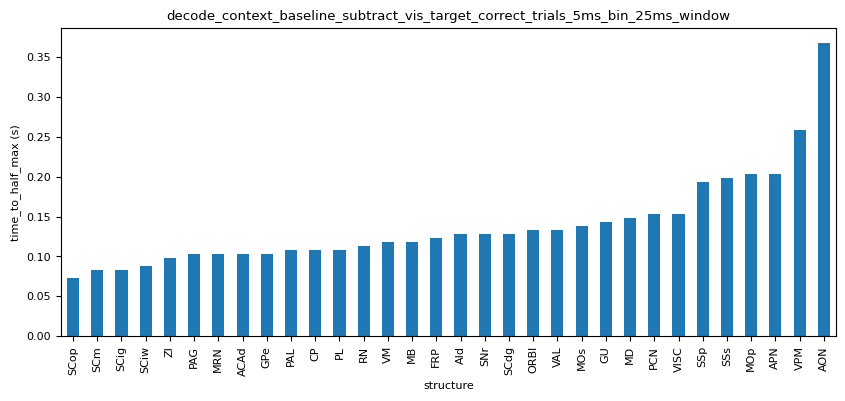

In [22]:
# sel_key='context_baseline_subtract_aud_stim_10units'
# sel_key='context_baseline_subtract_vis_stim_10units'
# sel_key='response_all_trials_no_baseline_subtract'
# sel_key='aud_stim_all_blocks'
sel_key='decode_context_baseline_subtract_vis_target_correct_trials_5ms_bin_25ms_window'
plot_col='time_to_half_max'
min_n_sessions=4


fig,ax=plt.subplots(1,1,figsize=(10,4))
sorted_df=mean_result_by_structure_df.query(f"result=='{sel_key}' and n_sessions>=@min_n_sessions and max_decoding_accuracy>=0.70").sort_values(by=plot_col)
sorted_df.plot.bar(x='structure', y=plot_col, ax=ax, legend=False)
ax.set_ylabel(f"{plot_col} (s)")
ax.set_title(f"{sel_key}")

In [ ]:
sel_keys=[
    # 'context_all_trials',
    # 'response_all_trials_no_baseline_subtract',
    # 'aud_stim_all_blocks',
    # 'vis_stim_all_blocks'

    'context_baseline_subtract_aud_stim_10units',
    'response_baseline_subtract_aud_stim_10units',
    'aud_stim_all_blocks_10units'

    # 'context_baseline_subtract_vis_stim_10units',
    # 'response_baseline_subtract_vis_stim_10units',
    # 'vis_stim_all_blocks_10units'
]

structure_exclude_list=['TH','MB','SCig','SCiw','SCop','SCsg','SCzo','SCdg','SCdw']

# plot_col='time_to_90_pct'
plot_col='time_to_75_pct'
# plot_col='time_to_half_max'
min_n_sessions=4

set_min_decoding_accuracy=0.60

sel_results_by_structure={
    'structure':mean_result_by_structure_df.query(
        f"result=='{sel_keys[0]}' and n_sessions>=@min_n_sessions and \
        max_decoding_accuracy>=@set_min_decoding_accuracy and \
        structure not in @structure_exclude_list").sort_values(by=plot_col)['structure'].values,
}

# (max_decoding_accuracy>=@set_min_decoding_accuracy or structure=='VISp') and \

sel_structures=sel_results_by_structure['structure']

for sel_key in sel_keys:
    
    sel_results_by_structure[sel_key]=[]

    for sel_structure in sel_structures:
        temp_df=mean_result_by_structure_df.query(
            f"result=='{sel_key}' and structure=='{sel_structure}' and n_sessions>=@min_n_sessions")
        if len(temp_df)==1:
            sel_results_by_structure[sel_key].append(temp_df[plot_col].values[0])
        else:
            sel_results_by_structure[sel_key].append(np.nan)
    
sel_results_by_structure_df=pd.DataFrame(sel_results_by_structure)

fig,ax=plt.subplots(1,1,figsize=(12,4))
sorted_df=sel_results_by_structure_df.sort_values(by=sel_keys[0]).dropna()
sorted_df.plot.bar(x='structure', y=sel_keys, ax=ax)
ax.set_ylabel(f"{plot_col} (s)")
ax.set_title("decoding latencies")

In [ ]:
# decoding_result[:,np.where(bins==bb)[0][0]]-0.5

In [ ]:
# mean_result_by_structure_df=pd.DataFrame(mean_result_by_structure)
mean_result_by_structure_df.query('result=="context_cumulative" and n_sessions>=5 and max_decoding_accuracy>=0.60')
# mean_result_by_structure_df.query('structure=="ORBl"')

In [ ]:
new_results_session_pd['n_passing_blocks'].unique()

In [ ]:
sel_structure='MOs'
sel_session="664851_2023-11-13"
# sel_key='context_all_trials'
sel_key='context_baseline_subtract_vis_stim_10units'
new_results_session_pd = results_dfs[sel_key]
test_vect=new_results_session_pd.query(f'structure=="{sel_structure}" and time_aligned_to=="{sel_time_aligned_to}" and session_id=="{sel_session}"').sort_values('bin_center')['mean_true'].values
test_bins=new_results_session_pd.query(f'structure=="{sel_structure}" and time_aligned_to=="{sel_time_aligned_to}" and session_id=="{sel_session}"').sort_values('bin_center')['bin_center'].values

half_max_value=(test_vect-0.5).max()/2 +0.5
time_to_half_max=test_bins[np.where(test_vect >= half_max_value)[0][0]]

fig,ax=plt.subplots(1,1,figsize=(5,4))
ax.axvline(x=0, color='grey', linestyle='--', linewidth=0.5)
ax.axvline(x=0.5, color='grey', linestyle='--', linewidth=0.5)
ax.axhline(y=0.5, color='grey', linestyle='--', linewidth=0.5)
ax.plot(test_bins, test_vect)
ax.plot(time_to_half_max, half_max_value, 'ro')
ax.set_title(f"{sel_structure}; {sel_key};\n{sel_session};  time to half max: {time_to_half_max:.3f}s")

In [ ]:
sel_structure='ORBl'
# sel_key='vis_stim_all_blocks'
# sel_key='context_all_trials'
sel_key='context_baseline_subtract_vis_stim_10units'
new_results_session_pd = results_dfs[sel_key]

# savepath=r"C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2025-10-01-decoding_latency"

test_df=new_results_session_pd.query(
    f'structure=="{sel_structure}" and time_aligned_to=="{sel_time_aligned_to}"'
    ).sort_values(
        ['session_id','bin_center']
    ).groupby(['session_id'])

n_sessions=len(test_df['session_id'].unique())

decoding_result=np.vstack(test_df['mean_true'].apply(np.array).values)
bins=test_df['bin_center'].apply(np.array).values[0]
if 'cumulative' in sel_key:
    time_offset=0.0
else:
    time_offset=0.025
bins=bins+time_offset


fig,ax=plt.subplots(1,1,figsize=(5,4))
ax.axvline(x=0, color='grey', linestyle='--', linewidth=0.5)
ax.axvline(x=0.5, color='grey', linestyle='--', linewidth=0.5)
ax.axhline(y=0.5, color='grey', linestyle='--', linewidth=0.5)
ax.plot(bins, decoding_result.T, color='lightgrey', alpha=0.5)
ax.plot(bins, np.mean(decoding_result,axis=0), color='black')
ax.set_ylabel('decoding accuracy')
ax.set_xlabel('time rel to stim onset (s)')
ax.set_title(f"{sel_structure}; {sel_key};\n{n_sessions} sessions")
# fig.savefig(os.path.join(savepath, f"{sel_structure}_{sel_key}_decoding_latency.png"), dpi=300)

Text(0.5, 1.0, 'SCm; decode_context_baseline_subtract_vis_target_correct_trials_5ms_bin_25ms_window;\n38 sessions; mean time to 90% max: 0.251s\n time to 90% max (mean accuracy): 0.228s')

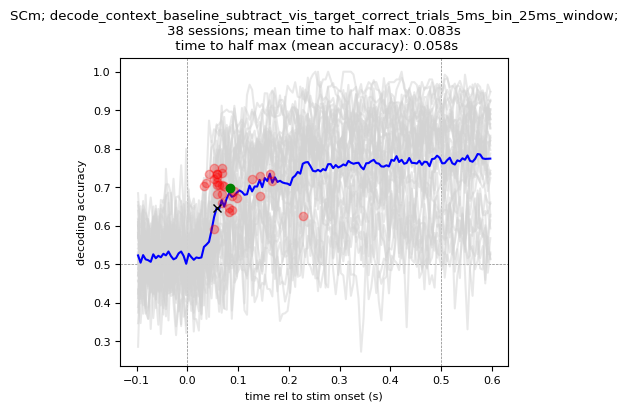

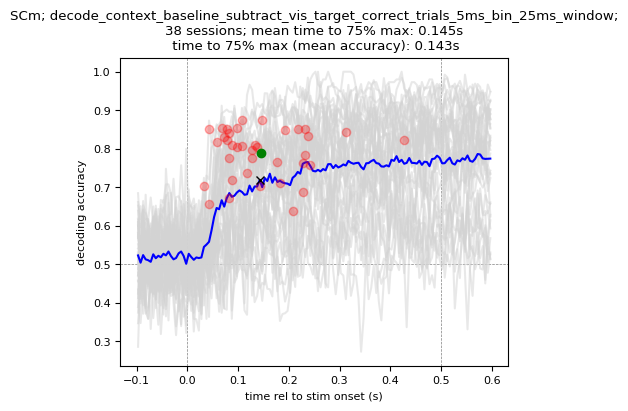

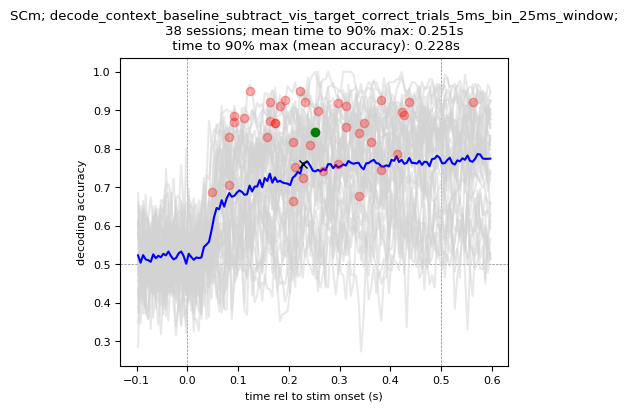

In [25]:
sel_structure='SCm'
# sel_key='vis_stim_all_blocks'
# sel_key='context_all_trials'
# sel_key='context_baseline_subtract_vis_stim_10units'
sel_key='decode_context_baseline_subtract_vis_target_correct_trials_5ms_bin_25ms_window'
new_results_session_pd = results_dfs[sel_key]

savepath=r"C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2025-10-01-decoding_latency"

test_df=new_results_session_pd.query(
    f'structure=="{sel_structure}" and time_aligned_to=="{sel_time_aligned_to}"'
    ).sort_values(
        ['session_id','bin_center']
    ).groupby(['session_id'])

half_max_value=[]
time_to_half_max=[]
pct_75_value=[]
time_to_75_pct=[]
pct_90_value=[]
time_to_90_pct=[]

n_sessions=len(test_df['session_id'].unique())

decoding_result=np.vstack(test_df['mean_true'].apply(np.array).values)
bins=test_df['bin_center'].apply(np.array).values[0]
if 'cumulative' in sel_key:
    time_offset=0.0
else:
    time_offset=0#0.025
bins=bins+time_offset

for ii in range(decoding_result.shape[0]):    
    temp_half_max_value=(decoding_result[ii,:]-0.5).max()/2 +0.5
    temp_time_to_half_max=bins[np.where(decoding_result[ii,:] >= temp_half_max_value)[0][0]]
    
    half_max_value.append(temp_half_max_value)
    time_to_half_max.append(temp_time_to_half_max)

    pct_75_value.append((decoding_result[ii,:]-0.5).max()*0.75 +0.5)
    time_to_75_pct.append(bins[np.where(decoding_result[ii,:] >= pct_75_value[-1])[0][0]])

    pct_90_value.append((decoding_result[ii,:]-0.5).max()*0.9 +0.5)
    time_to_90_pct.append(bins[np.where(decoding_result[ii,:] >= pct_90_value[-1])[0][0]])

#remove negative times (before stim onset)
half_max_value=np.array(half_max_value)[np.array(time_to_half_max)>=0]
time_to_half_max=np.array(time_to_half_max)[np.array(time_to_half_max)>=0]
pct_75_value=np.array(pct_75_value)[np.array(time_to_75_pct)>=0]
time_to_75_pct=np.array(time_to_75_pct)[np.array(time_to_75_pct)>=0]
pct_90_value=np.array(pct_90_value)[np.array(time_to_90_pct)>=0]
time_to_90_pct=np.array(time_to_90_pct)[np.array(time_to_90_pct)>=0]

mean_half_max_value=np.mean(half_max_value)
mean_time_to_half_max=np.mean(time_to_half_max)
mean_pct_75_value=np.mean(pct_75_value)
mean_time_to_75_pct=np.mean(time_to_75_pct)
mean_pct_90_value=np.mean(pct_90_value)
mean_time_to_90_pct=np.mean(time_to_90_pct)

example_timebin_decoding=np.mean(decoding_result, axis=0)
single_half_max_value=(example_timebin_decoding-0.5).max()/2 +0.5
single_time_to_half_max=bins[np.where(example_timebin_decoding >= single_half_max_value)[0][0]]
single_half_max_value=example_timebin_decoding[np.where(example_timebin_decoding >= single_half_max_value)[0][0]]

single_pct_75_value=(example_timebin_decoding-0.5).max()*0.75 +0.5
single_time_to_75_pct=bins[np.where(example_timebin_decoding >= single_pct_75_value)[0][0]]
single_pct_75_value=example_timebin_decoding[np.where(example_timebin_decoding >= single_pct_75_value)[0][0]]

single_pct_90_value=(example_timebin_decoding-0.5).max()*0.9 +0.5
single_time_to_90_pct=bins[np.where(example_timebin_decoding >= single_pct_90_value)[0][0]]
single_pct_90_value=example_timebin_decoding[np.where(example_timebin_decoding >= single_pct_90_value)[0][0]]


#half max
fig,ax=plt.subplots(1,1,figsize=(5,4))
ax.axvline(x=0, color='grey', linestyle='--', linewidth=0.5)
ax.axvline(x=0.5, color='grey', linestyle='--', linewidth=0.5)
ax.axhline(y=0.5, color='grey', linestyle='--', linewidth=0.5)
ax.plot(bins, decoding_result.T, color='lightgrey', alpha=0.5)
ax.plot(bins, np.mean(decoding_result,axis=0), color='blue')
ax.plot(time_to_half_max, half_max_value, 'ro', alpha=0.3)
ax.plot(mean_time_to_half_max, mean_half_max_value, 'go')
ax.plot(single_time_to_half_max, single_half_max_value, 'kx')
ax.set_ylabel('decoding accuracy')
ax.set_xlabel('time rel to stim onset (s)')
ax.set_title(f"{sel_structure}; {sel_key};\n{n_sessions} sessions; mean time to half max: {mean_time_to_half_max:.3f}s\n time to half max (mean accuracy): {single_time_to_half_max:.3f}s")
# fig.savefig(os.path.join(savepath, f"{sel_structure}_{sel_key}_decoding_latency.png"), dpi=300)

#75 pct
fig,ax=plt.subplots(1,1,figsize=(5,4))
ax.axvline(x=0, color='grey', linestyle='--', linewidth=0.5)
ax.axvline(x=0.5, color='grey', linestyle='--', linewidth=0.5)
ax.axhline(y=0.5, color='grey', linestyle='--', linewidth=0.5)
ax.plot(bins, decoding_result.T, color='lightgrey', alpha=0.5)
ax.plot(bins, np.mean(decoding_result,axis=0), color='blue')
ax.plot(time_to_75_pct, pct_75_value, 'ro', alpha=0.3)
ax.plot(mean_time_to_75_pct, mean_pct_75_value, 'go')
ax.plot(single_time_to_75_pct, single_pct_75_value, 'kx')
ax.set_ylabel('decoding accuracy')
ax.set_xlabel('time rel to stim onset (s)')
ax.set_title(f"{sel_structure}; {sel_key};\n{n_sessions} sessions; mean time to 75% max: {mean_time_to_75_pct:.3f}s\n time to 75% max (mean accuracy): {single_time_to_75_pct:.3f}s")
# fig.savefig(os.path.join(savepath, f"{sel_structure}_{sel_key}_decoding_latency_75pct.png"), dpi=300)

#90 pct
fig,ax=plt.subplots(1,1,figsize=(5,4))
ax.axvline(x=0, color='grey', linestyle='--', linewidth=0.5)
ax.axvline(x=0.5, color='grey', linestyle='--', linewidth=0.5)
ax.axhline(y=0.5, color='grey', linestyle='--', linewidth=0.5)
ax.plot(bins, decoding_result.T, color='lightgrey', alpha=0.5)
ax.plot(bins, np.mean(decoding_result,axis=0), color='blue')
ax.plot(time_to_90_pct, pct_90_value, 'ro', alpha=0.3)
ax.plot(mean_time_to_90_pct, mean_pct_90_value, 'go')
ax.plot(single_time_to_90_pct, single_pct_90_value, 'kx')
ax.set_ylabel('decoding accuracy')
ax.set_xlabel('time rel to stim onset (s)')
ax.set_title(f"{sel_structure}; {sel_key};\n{n_sessions} sessions; mean time to 90% max: {mean_time_to_90_pct:.3f}s\n time to 90% max (mean accuracy): {single_time_to_90_pct:.3f}s")
# fig.savefig(os.path.join(savepath, f"{sel_structure}_{sel_key}_decoding_latency_90pct.png"), dpi=300)

In [ ]:
decoding_result[0]

In [ ]:
# test_df['mean_true'].apply(np.array).values
# test_df['bin_center'].apply(np.array).values[0]
# results[0].shape
# bins[1]+time_offset
# test_df['session_id'].unique()

In [ ]:
def get_session_results(session_id,results_path,grouping_cols,combine_multi_probe_expr):

    decoder_coefs = (
        pl.scan_parquet(results_path)
        .filter(
            pl.col('session_id').eq(session_id),
        )
        .with_columns(
            pl.col('electrode_group_names').flatten().n_unique().eq(1).over(grouping_cols - {'electrode_group_names'}).alias('is_sole_recording'),     
        )
        .filter(
            combine_multi_probe_expr,
            pl.col('is_all_trials').eq(True),
        )
        .sort('structure', 'shift_idx', 'repeat_idx', 'time_aligned_to', 'bin_center', descending=False, maintain_order=True)
        .with_columns([
            pl.col("electrode_group_names").list.n_unique().alias("n_probes"),
            pl.col("electrode_group_names")
            .list.eval(pl.element().str.replace("probe", ""))
            .list.join("")
            .alias("probe")
        ])
        .drop('predict_proba','predict_proba_all_trials','trial_indices','electrode_group_names','repeat_idx','shift_idx','unit_subsample_size','unit_criteria','is_sole_recording','is_all_trials','time_aligned_to')
        .collect()
    )

    return decoder_coefs #.to_pandas()

def get_session_coef_results(session_id,results_paths):

    session_coef_dfs={}

    for key, results_path in results_paths.items():
        print(f"Loading results from {key}...")
        session_coef_dfs[key] = pl.scan_parquet(results_path).filter(pl.col('session_id').eq(session_id)).collect().to_pandas()

    return session_coef_dfs


def get_structure_coefs(structure, results_path, results_key, session_list=None):
    if session_list is not None:
        structure_coefs = pl.scan_parquet(results_path[results_key]).filter(
            pl.col('structure').eq(structure) & pl.col('session_id').is_in(session_list)
        ).collect().to_pandas()
    else:
        structure_coefs = pl.scan_parquet(results_path[results_key]).filter(
            pl.col('structure').eq(structure)
        ).collect().to_pandas()

    structure_coefs['results_key'] = results_key
    structure_coefs['results_path'] = results_path[results_key]

    return structure_coefs

In [ ]:
#test loading the whole result path

savepath=r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\coefficient_summary_tables_separate_stim_modality_2025-10-08"

for key in results_paths.keys():

    # if key=='context_all_trials':
    #     continue
    print(f"Loading full results from {key}...")

    results_path=results_paths[key]

    decoder_coefs = (
        pl.scan_parquet(results_path)
        .with_columns(
            pl.col('electrode_group_names').flatten().n_unique().eq(1).over(grouping_cols - {'electrode_group_names'}).alias('is_sole_recording'),     
        )
        .filter(
            combine_multi_probe_expr,
            pl.col('is_all_trials').eq(True),
        )
        .sort('structure', 'shift_idx', 'repeat_idx', 'time_aligned_to', 'bin_center', descending=False, maintain_order=True)
        .with_columns([
            pl.col("electrode_group_names").list.n_unique().alias("n_probes"),
            pl.col("electrode_group_names")
            .list.eval(pl.element().str.replace("probe", ""))
            .list.join("")
            .alias("probe")
        ])
        .drop('predict_proba','predict_proba_all_trials','trial_indices','electrode_group_names','repeat_idx','shift_idx','unit_subsample_size','unit_criteria','is_sole_recording','is_all_trials','time_aligned_to')
        .collect()
    )
    print(f"Loaded {decoder_coefs.shape[0]} rows from {key}.")
    decoder_coefs.write_parquet(os.path.join(savepath, key + "_decoder_coefs.parquet"))


In [ ]:
# # decoder_coefs.write_parquet(r"D:\context_all_trials_decoder_coefs.parquet")
# results_paths_processed={
#     'context_all_trials_no_baseline_subtract': r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\coefficient_summary_tables_2025-09-15\context_all_trials_no_baseline_subtract_decoder_coefs.parquet",
#     'context_all_trials': r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\coefficient_summary_tables_2025-09-15\context_all_trials_decoder_coefs.parquet",
#     'context_cumulative': r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\coefficient_summary_tables_2025-09-15\context_cumulative_decoder_coefs.parquet",
#     'context_aud_target': r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\coefficient_summary_tables_2025-09-15\context_aud_target_decoder_coefs.parquet",
#     'context_vis_target': r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\coefficient_summary_tables_2025-09-15\context_vis_target_decoder_coefs.parquet",
#     'response_all_trials': r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\coefficient_summary_tables_2025-09-15\response_all_trials_decoder_coefs.parquet",
#     'response_aud_target': r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\coefficient_summary_tables_2025-09-15\response_aud_target_decoder_coefs.parquet",
#     'response_vis_target': r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\coefficient_summary_tables_2025-09-15\response_vis_target_decoder_coefs.parquet",
#     'aud_stim_in_aud_context': r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\coefficient_summary_tables_2025-09-15\aud_stim_in_aud_context_decoder_coefs.parquet",
#     'aud_stim_in_vis_context': r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\coefficient_summary_tables_2025-09-15\aud_stim_in_vis_context_decoder_coefs.parquet",
#     'vis_stim_in_aud_context': r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\coefficient_summary_tables_2025-09-15\vis_stim_in_aud_context_decoder_coefs.parquet",
#     'vis_stim_in_vis_context': r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\coefficient_summary_tables_2025-09-15\vis_stim_in_vis_context_decoder_coefs.parquet",    
# }

# results_paths_processed={
#     'context_all_trials_no_baseline_subtract': r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\coefficient_summary_tables_2025-09-22\context_all_trials_no_baseline_subtract_decoder_coefs.parquet",
#     'context_all_trials': r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\coefficient_summary_tables_2025-09-22\context_all_trials_decoder_coefs.parquet",
#     'response_all_trials_no_baseline_subtract': r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\coefficient_summary_tables_2025-09-22\response_all_trials_no_baseline_subtract_decoder_coefs.parquet",
#     'response_all_trials': r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\coefficient_summary_tables_2025-09-22\response_all_trials_decoder_coefs.parquet",
#     'aud_stim_all_blocks': r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\coefficient_summary_tables_2025-09-22\aud_stim_all_blocks_decoder_coefs.parquet",
#     'aud_stim_all_blocks_baseline_subtract': r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\coefficient_summary_tables_2025-09-22\aud_stim_all_blocks_baseline_subtract_decoder_coefs.parquet",
#     'vis_stim_all_blocks': r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\coefficient_summary_tables_2025-09-22\vis_stim_all_blocks_decoder_coefs.parquet",
#     'vis_stim_all_blocks_baseline_subtract': r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\coefficient_summary_tables_2025-09-22\vis_stim_all_blocks_baseline_subtract_decoder_coefs.parquet",
# }

results_paths_processed={
    'context_no_baseline_subtract_aud_stim_10units': r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\coefficient_summary_tables_separate_stim_modality_2025-10-08\context_no_baseline_subtract_aud_stim_10units_decoder_coefs.parquet",
    'context_baseline_subtract_aud_stim_10units': r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\coefficient_summary_tables_separate_stim_modality_2025-10-08\context_baseline_subtract_aud_stim_10units_decoder_coefs.parquet",
    'context_no_baseline_subtract_vis_stim_10units': r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\coefficient_summary_tables_separate_stim_modality_2025-10-08\context_no_baseline_subtract_vis_stim_10units_decoder_coefs.parquet",
    'context_baseline_subtract_vis_stim_10units': r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\coefficient_summary_tables_separate_stim_modality_2025-10-08\context_baseline_subtract_vis_stim_10units_decoder_coefs.parquet",
    'response_aud_stim_10units': r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\coefficient_summary_tables_separate_stim_modality_2025-10-08\response_aud_stim_10units_decoder_coefs.parquet",
    'response_baseline_subtract_aud_stim_10units': r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\coefficient_summary_tables_separate_stim_modality_2025-10-08\response_baseline_subtract_aud_stim_10units_decoder_coefs.parquet",
    'response_vis_stim_10units': r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\coefficient_summary_tables_separate_stim_modality_2025-10-08\response_vis_stim_10units_decoder_coefs.parquet",
    'response_baseline_subtract_vis_stim_10units': r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\coefficient_summary_tables_separate_stim_modality_2025-10-08\response_baseline_subtract_vis_stim_10units_decoder_coefs.parquet",
    'aud_stim_all_blocks_10units': r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\coefficient_summary_tables_separate_stim_modality_2025-10-08\aud_stim_all_blocks_10units_decoder_coefs.parquet",
    'vis_stim_all_blocks_10units': r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\coefficient_summary_tables_separate_stim_modality_2025-10-08\vis_stim_all_blocks_10units_decoder_coefs.parquet",
}

In [ ]:



sel_session_id="664851_2023-11-13"
results_key_0='context_all_trials_no_baseline_subtract'
results_key_1='context_all_trials'
results_path_0=results_paths[results_key_0]
results_path_1=results_paths[results_key_1]

decoder_coefs_pd_0 = get_session_results(sel_session_id, results_path_0, grouping_cols, combine_multi_probe_expr)
decoder_coefs_pd_1 = get_session_results(sel_session_id, results_path_1, grouping_cols, combine_multi_probe_expr)

decoder_coefs_pd_0=decoder_coefs_pd_0.to_pandas()
decoder_coefs_pd_1=decoder_coefs_pd_1.to_pandas()

In [ ]:
sel_session_id="664851_2023-11-13"
session_coef_dfs = get_session_coef_results(sel_session_id, results_paths_processed)

In [ ]:
#get all coefs from one structure and result across sessions (optinoal session filter)

sel_structure='ORBl'
results_key='context_all_trials_no_baseline_subtract'
sel_time_aligned_to='stim_start_time'

structure_coef_df = get_structure_coefs(sel_structure, results_paths_processed, results_key, dr_session_list)

structure_coef_df['bin_center'] = (structure_coef_df['bin_center'] + 0.025).round(3)


In [ ]:
sel_time_bin=0.10
xbins=np.arange(-2,2,0.1)
flattened_coefs = np.hstack(structure_coef_df.query('bin_center==@sel_time_bin')['coefs'].values)

fig,ax=plt.subplots(1,1,figsize=(8,4))
ax.axvline(x=0, color='black', linestyle='--', linewidth=0.5)
ax.hist(flattened_coefs, bins=xbins)
ax.set_title(f"{sel_structure}; {results_key}; {sel_time_bin}s; n={len(flattened_coefs)} coefs")

In [ ]:
#compare distribution of coefs between multipl results
sel_structure='CP'
# results_keys=['context_all_trials_no_baseline_subtract', 'context_all_trials',
#               'response_all_trials_no_baseline_subtract',
#               'vis_stim_all_blocks', 'aud_stim_all_blocks']
# results_keys=['context_all_trials_no_baseline_subtract', 
#               'response_all_trials_no_baseline_subtract',]
results_keys=['context_all_trials_no_baseline_subtract', 'context_all_trials']
sel_time_aligned_to='stim_start_time'
sel_time_bin=0.10

xbins=np.arange(-2,2,0.1)
fig,ax=plt.subplots(1,1,figsize=(8,4))
ax.axvline(x=0, color='black', linestyle='--', linewidth=0.5)

for results_key in results_keys:
    structure_coef_df = get_structure_coefs(sel_structure, results_paths_processed, results_key, dr_session_list)
    structure_coef_df['bin_center'] = (structure_coef_df['bin_center'] + 0.025).round(3)

    flattened_coefs = np.hstack(structure_coef_df.query('bin_center==@sel_time_bin')['coefs'].values)
    ax.hist(flattened_coefs, bins=xbins, alpha=0.5, label=results_key)

ax.set_title(f"{sel_structure}; {sel_time_bin}s; n={len(flattened_coefs)} coefs")
ax.set_xlabel('decoder coefficient value')
ax.set_ylabel('count')
ax.legend()


In [ ]:
sel_structure='ORBl'
sel_bin_center=0.075

plot_bins=np.arange(-2,2.01,0.1)

decoder_coefs_pd_0['bin_center']=decoder_coefs_pd_0['bin_center'].round(3)
decoder_coefs_pd_1['bin_center']=decoder_coefs_pd_1['bin_center'].round(3)

fig,ax=plt.subplots(1,1,figsize=(5,4))

ax.axvline(x=0, color='grey', linestyle='--', linewidth=0.5)
ax.hist(decoder_coefs_pd_0.query(f'structure=="{sel_structure}" and bin_center=={sel_bin_center}')['coefs'].values[0], bins=plot_bins, alpha=0.5, label=results_key_0)
ax.hist(decoder_coefs_pd_1.query(f'structure=="{sel_structure}" and bin_center=={sel_bin_center}')['coefs'].values[0], bins=plot_bins, alpha=0.5, label=results_key_1)
ax.legend()

In [ ]:
sel_structure='ORBl'
sel_bin_center=0.075

fig,ax=plt.subplots(1,1,figsize=(5,4))

ax.axvline(x=0, color='grey', linestyle='--', linewidth=0.5)
ax.axhline(y=0, color='grey', linestyle='--', linewidth=0.5)
ax.plot(decoder_coefs_pd_0.query(f'structure=="{sel_structure}" and bin_center=={sel_bin_center}')['coefs'].values[0], 
        decoder_coefs_pd_1.query(f'structure=="{sel_structure}" and bin_center=={sel_bin_center}')['coefs'].values[0], 'k.')
# ax.legend()

In [ ]:
corrcoef_by_timepoint={
    'results_key_0': [],
    'results_key_1': [],
    'structure': [],
    'bin_center': [],
    'bin_center_1': [],
    'corrcoef': [],
    'cosine_similarity': [],
    'euclidean_distance': [],
}

#get unique structures across all results
unique_structures = set()
for df in session_coef_dfs.values():
    unique_structures.update(df['structure'].unique())
unique_structures = sorted(unique_structures)

# make list of all combinations of results keys
results_keys = list(session_coef_dfs.keys())
combinations = [(key0, key1) for i, key0 in enumerate(results_keys) for key1 in results_keys[i+1:]]

# loop through combinations of results keys
for key0, key1 in combinations:

    # find correlation between coefs
    df0 = session_coef_dfs[key0].copy()
    df1 = session_coef_dfs[key1].copy()

    #TODO: fix this hack for shifting timepoints
    if 'cumulative' not in key0:
        df0['bin_center'] = df0['bin_center'] + 0.025
    if 'cumulative' not in key1:
        df1['bin_center'] = df1['bin_center'] + 0.025

    #round bin centers to 3 decimal places
    df0['bin_center'] = df0['bin_center'].round(3)
    df1['bin_center'] = df1['bin_center'].round(3)

    #check that timepoints match up
    timepoints0 = df0.query('structure==@structure')['bin_center'].unique()
    timepoints1 = df1.query('structure==@structure')['bin_center'].unique()

    if not np.array_equal(timepoints0, timepoints1):
        print(f"Timepoints do not match for {key1} and {key0}. Finding best match.")
        # continue

        # Find closest timepoints more efficiently
        timepoints0 = np.array(sorted(timepoints0))
        timepoints1 = np.array(sorted(timepoints1))
        
        # Use broadcasting to compute all pairwise distances at once
        distances = np.abs(timepoints0[:, np.newaxis] - timepoints1[np.newaxis, :])
        closest_indices = np.argmin(distances, axis=1)
        min_distances = distances[np.arange(len(timepoints0)), closest_indices]
        
        # Filter out matches with distance >= 0.01
        valid_matches = min_distances < 0.01
        
        if not np.any(valid_matches):
            print(f"No close matches found between {key0} and {key1}. Skipping.")
            continue
            
        timepoints0 = timepoints0[valid_matches].round(3)
        timepoints1 = timepoints1[closest_indices[valid_matches]].round(3)
        
        if len(timepoints0) < len(np.array(sorted(df0.query('structure==@structure')['bin_center'].unique()))):
            print(f"Only {len(timepoints0)} matches found between {key0} and {key1}.")

    #loop through structures
    for structure in unique_structures:

        for timepoint0,timepoint1 in zip(timepoints0, timepoints1):

            vec0=df0.query('structure==@structure and bin_center==@timepoint0')['coefs'].values[0]
            vec1=df1.query('structure==@structure and bin_center==@timepoint1')['coefs'].values[0]
            corr=np.corrcoef(vec0, vec1)[0,1]
            cosine_sim = np.dot(vec0, vec1) / (np.linalg.norm(vec0) * np.linalg.norm(vec1))
            euclidean_dist = np.linalg.norm(vec0 - vec1)
            
            corrcoef_by_timepoint['results_key_0'].append(key0)
            corrcoef_by_timepoint['results_key_1'].append(key1)
            corrcoef_by_timepoint['structure'].append(structure)
            corrcoef_by_timepoint['bin_center'].append(timepoint0)
            corrcoef_by_timepoint['bin_center_1'].append(timepoint1)
            corrcoef_by_timepoint['corrcoef'].append(corr)
            corrcoef_by_timepoint['cosine_similarity'].append(cosine_sim)
            corrcoef_by_timepoint['euclidean_distance'].append(euclidean_dist)


In [ ]:
# df0.query('structure==@structure and bin_center==@timepoint0')
# timepoints0
df0.query('structure==@structure and bin_center==@timepoint0')
df1.query('structure==@structure and bin_center==@timepoint1')
# timepoint0

In [ ]:
corrcoef_by_timepoint_df=pd.DataFrame(corrcoef_by_timepoint)
corrcoef_by_timepoint_df

In [ ]:
# savepath=r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\coefficient_summary_tables_2025-09-15\coef_corr_by_session"
# corrcoef_by_timepoint_df.to_parquet(os.path.join(savepath, f"{sel_session_id}_coef_corr_by_timepoint.parquet"))

In [ ]:
corrcoef_by_timepoint_df['bin_center']=corrcoef_by_timepoint_df['bin_center'].round(3)
results_keys = list(session_coef_dfs.keys())

#plot heatmap of correlation coefficients for each results pair
sel_structure='FRP'
sel_bin_center=0.05

#build correlation matrix from this dataframe
corr_matrix=np.full((len(results_keys), len(results_keys)), np.nan)
for rr, sel_key_0 in enumerate(results_keys):
    for cc, sel_key_1 in enumerate(results_keys):
        if sel_key_0==sel_key_1:
            corr_matrix[rr,cc]=np.nan
        else:
            temp_corr=corrcoef_by_timepoint_df.query(f'results_key_0=="{sel_key_0}" and results_key_1=="{sel_key_1}" and \
                                                   structure=="{sel_structure}" and bin_center=={sel_bin_center}')['corrcoef'].values
            if len(temp_corr)==1:
                corr_matrix[rr,cc]=temp_corr[0]
                corr_matrix[cc,rr]=temp_corr[0]

fig,ax=plt.subplots(1,1,figsize=(7,6))

masked_array = np.ma.array(corr_matrix, mask=np.isnan(corr_matrix))
cmap = matplotlib.cm.bwr
cmap.set_bad('grey',0.5)

im=ax.imshow(masked_array, aspect='auto', cmap=cmap, vmin=-0.75, vmax=0.75, extent=[-0.5,len(results_keys)-0.5,len(results_keys)-0.5,-0.5])
ax.set_xticks(np.arange(len(results_keys)), results_keys, rotation=90)
ax.set_yticks(np.arange(len(results_keys)), results_keys)

#colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('mean Pearson r between unit coefs')
ax.set_title(f"Correlation of decoder coefficients\n{sel_structure} at {sel_bin_center}s; session {sel_session_id}")


In [ ]:
#compare selected result to all others over time with heatmap
sel_key='vis_stim_in_vis_context'
sel_structure='ACAd'

timebins=np.sort(corrcoef_by_timepoint_df['bin_center'].unique().round(3))

fig,ax=plt.subplots(1,1,figsize=(8,4))
heatmap_data=np.full((len(results_keys), len(timebins)), np.nan)
for rr, sel_key_1 in enumerate(results_keys):
    if sel_key_1==sel_key:
        continue
    for cc, sel_bin_center in enumerate(timebins):
        temp_corr=corrcoef_by_timepoint_df.query(f'results_key_0=="{sel_key}" and results_key_1=="{sel_key_1}" and \
                                               structure=="{sel_structure}" and bin_center=={sel_bin_center}')['corrcoef'].values
        if len(temp_corr)==0:
            temp_corr=corrcoef_by_timepoint_df.query(f'results_key_1=="{sel_key}" and results_key_0=="{sel_key_1}" and \
                                                   structure=="{sel_structure}" and bin_center=={sel_bin_center}')['corrcoef'].values
        if len(temp_corr)==1:
            heatmap_data[rr,cc]=temp_corr[0]
        
im=ax.imshow(heatmap_data, aspect='auto', cmap='bwr', vmin=-0.75, vmax=0.75, extent=[timebins[0]-0.025, timebins[-1]+0.025, len(results_keys)-0.5, -0.5])
ax.set_yticks(np.arange(len(results_keys)), results_keys)
# ax.set_xticks(np.arange(len(timebins)), timebins, rotation=90)
ax.set_xlabel('time rel to stim onset (s)')
ax.set_ylabel('results key')
#colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label(f'Pearson r between unit coefs\n{sel_key} vs other results')
ax.set_title(f"Correlation with {sel_key}\n{sel_structure}; session {sel_session_id}")

In [ ]:
#compute and save correlations by session
savepath=r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\coefficient_summary_tables_separate_stim_modality_2025-10-08\coef_corr_by_session"

all_session_list=(
    session_table.filter(
    pl.col('project')=="DynamicRouting",
    pl.col('is_production'),
    pl.col('is_annotated'),
    pl.col('issues')=="",
    pl.col('is_engaged'),
    pl.col('is_good_behavior').eq(True),
    )['session_id'].to_list()
    )

error_dict={}

for sel_session_id in all_session_list:
    # try:
        session_coef_dfs = get_session_coef_results(sel_session_id, results_paths_processed)

        corrcoef_by_timepoint={
            'session_id':[],
            'results_key_0': [],
            'results_key_1': [],
            'structure': [],
            'bin_center': [],
            'bin_center_1': [],
            'corrcoef': [],
            'cosine_similarity': [],
            'euclidean_distance': [],
        }

        #get unique structures across all results
        unique_structures = set()
        for df in session_coef_dfs.values():
            unique_structures.update(df['structure'].unique())
        unique_structures = sorted(unique_structures)

        # make list of all combinations of results keys
        results_keys = list(session_coef_dfs.keys())
        combinations = [(key0, key1) for i, key0 in enumerate(results_keys) for key1 in results_keys[i+1:]]

        # loop through combinations of results keys
        for key0, key1 in combinations:

            # find correlation between coefs
            df0 = session_coef_dfs[key0].copy()
            df1 = session_coef_dfs[key1].copy()

            if df0.shape[0]==0:
                print(f"No data for {sel_session_id} in {key0}. Skipping.")
                continue
            if df1.shape[0]==0:
                print(f"No data for {sel_session_id} in {key1}. Skipping.")
                continue

            # TODO: fix this hack for shifting timepoints
            if 'cumulative' not in key0:
                df0['bin_center'] = df0['bin_center'] + 0.025
            if 'cumulative' not in key1:
                df1['bin_center'] = df1['bin_center'] + 0.025

            #round bin centers to 3 decimal places
            df0['bin_center'] = df0['bin_center'].round(3)
            df1['bin_center'] = df1['bin_center'].round(3)

            #check that timepoints match up
            timepoints0 = df0['bin_center'].unique()
            timepoints1 = df1['bin_center'].unique()

            if not np.array_equal(timepoints0, timepoints1):
                print(f"Timepoints do not match for {key1} and {key0}. Finding best match.")
                # continue

                # Find closest timepoints more efficiently
                timepoints0 = np.array(sorted(timepoints0))
                timepoints1 = np.array(sorted(timepoints1))
                
                # Use broadcasting to compute all pairwise distances at once
                distances = np.abs(timepoints0[:, np.newaxis] - timepoints1[np.newaxis, :])
                closest_indices = np.argmin(distances, axis=1)
                min_distances = distances[np.arange(len(timepoints0)), closest_indices]
                
                # Filter out matches with distance >= 0.01
                valid_matches = min_distances < 0.01
                
                if not np.any(valid_matches):
                    print(f"No close matches found between {key0} and {key1}. Skipping.")
                    continue
                    
                timepoints0 = timepoints0[valid_matches].round(3)
                timepoints1 = timepoints1[closest_indices[valid_matches]].round(3)
                
                if len(timepoints0) < len(np.array(sorted(df0.query('structure==@structure')['bin_center'].unique()))):
                    print(f"Only {len(timepoints0)} matches found between {key0} and {key1}.")

            #loop through structures
            for structure in unique_structures:

                for timepoint0,timepoint1 in zip(timepoints0, timepoints1):

                    unit_ids_0=df0.query(f'structure=="{structure}" and bin_center=={timepoint0}')['unit_ids'].values[0]
                    unit_ids_1=df1.query(f'structure=="{structure}" and bin_center=={timepoint1}')['unit_ids'].values[0]

                    if np.any(unit_ids_0!=unit_ids_1):
                        print(f"Unit IDs do not match for {sel_session_id}, {structure}, {key0} at {timepoint0}s and {key1} at {timepoint1}s. Skipping.")
                        continue

                    vec0=df0.query('structure==@structure and bin_center==@timepoint0')['coefs'].values[0]
                    vec1=df1.query('structure==@structure and bin_center==@timepoint1')['coefs'].values[0]
                    corr=np.corrcoef(vec0, vec1)[0,1]
                    cosine_sim = np.dot(vec0, vec1) / (np.linalg.norm(vec0) * np.linalg.norm(vec1))
                    euclidean_dist = np.linalg.norm(vec0 - vec1)

                    corrcoef_by_timepoint['session_id'].append(sel_session_id)
                    corrcoef_by_timepoint['results_key_0'].append(key0)
                    corrcoef_by_timepoint['results_key_1'].append(key1)
                    corrcoef_by_timepoint['structure'].append(structure)
                    corrcoef_by_timepoint['bin_center'].append(timepoint0)
                    corrcoef_by_timepoint['bin_center_1'].append(timepoint1)
                    corrcoef_by_timepoint['corrcoef'].append(corr)
                    corrcoef_by_timepoint['cosine_similarity'].append(cosine_sim)
                    corrcoef_by_timepoint['euclidean_distance'].append(euclidean_dist)
                    
        corrcoef_by_timepoint_df=pd.DataFrame(corrcoef_by_timepoint)
        corrcoef_by_timepoint_df['bin_center']=corrcoef_by_timepoint_df['bin_center'].round(3)
        corrcoef_by_timepoint_df['bin_center_1']=corrcoef_by_timepoint_df['bin_center_1'].round(3)

        corrcoef_by_timepoint_df.to_parquet(os.path.join(savepath, f"{sel_session_id}_coef_corr_by_timepoint.parquet"))

    # except Exception as e:
    #     print(f"Error processing session {sel_session_id}: {e}")
    #     error_dict[sel_session_id]=str(e)
    #     continue

In [ ]:
loadpath=r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\coefficient_summary_tables_separate_stim_modality_2025-10-08\coef_corr_by_session"

coef_results_df = (
    pl.scan_parquet(loadpath)
).collect()



In [ ]:
# coef_results_pd
# # results_keys
# sel_key_0='context_aud_target'
# sel_key_1='response_aud_target'
# sel_structure='ACAd'
# sel_bin_center=0.05
coef_results_pd.query(f'results_key_0=="{sel_key_0}" and results_key_1=="{sel_key_1}" and \
                        structure=="{sel_structure}" and bin_center=={sel_bin_center}')['corrcoef'].mean()

In [ ]:
coef_results_pd=coef_results_df.to_pandas()
results_keys = list(results_paths.keys())

# results_keys=['context_all_trials_no_baseline_subtract',
#               'context_all_trials',
#               'response_all_trials_no_baseline_subtract',
#               'aud_stim_all_blocks',
#               'vis_stim_all_blocks',]

# results_keys=['context_no_baseline_subtract_aud_stim_10units',
#               'context_baseline_subtract_aud_stim_10units',
#               'context_no_baseline_subtract_vis_stim_10units',
#               'context_baseline_subtract_vis_stim_10units',
#               'response_aud_stim_10units',
#               'response_baseline_subtract_aud_stim_10units',
#               'response_vis_stim_10units',
#               'response_baseline_subtract_vis_stim_10units',
#               'aud_stim_all_blocks_10units',
#               'vis_stim_all_blocks_10units',]

results_keys=['context_no_baseline_subtract_aud_stim_10units',
              'response_baseline_subtract_aud_stim_10units',
              'aud_stim_all_blocks_10units',

              'context_no_baseline_subtract_vis_stim_10units',
              'response_baseline_subtract_vis_stim_10units',
              'vis_stim_all_blocks_10units',]

# results_keys=['context_baseline_subtract_aud_stim_10units',
#               'response_baseline_subtract_aud_stim_10units',
#               'aud_stim_all_blocks_10units',
#               'context_baseline_subtract_vis_stim_10units',
#               'response_baseline_subtract_vis_stim_10units',
#               'vis_stim_all_blocks_10units',]

#plot heatmap of correlation coefficients for each results pair
sel_structure='SCm'
sel_bin_center=-0.05

#build correlation matrix from this dataframe
corr_matrix=np.full((len(results_keys), len(results_keys)), np.nan)

for rr, sel_key_0 in enumerate(results_keys):
    temp_corr_row=[]
    for cc, sel_key_1 in enumerate(results_keys):
        temp_corr=coef_results_pd.query(f'results_key_0=="{sel_key_0}" and results_key_1=="{sel_key_1}" and \
                                                structure=="{sel_structure}" and bin_center=={sel_bin_center}')['corrcoef']
        if len(temp_corr)>0:
            temp_corr=temp_corr.mean()
            corr_matrix[rr,cc]=np.abs(temp_corr)
            corr_matrix[cc,rr]=np.abs(temp_corr)


fig,ax=plt.subplots(1,1,figsize=(5,4))

masked_array = np.ma.array(corr_matrix, mask=np.isnan(corr_matrix))
cmap = matplotlib.cm.viridis
cmap.set_bad('grey',0.5)

im=ax.imshow(masked_array, aspect='auto', cmap=cmap, vmin=0, vmax=0.5, extent=[-0.5,len(results_keys)-0.5,len(results_keys)-0.5,-0.5])
# im=ax.imshow(corr_matrix, aspect='auto', cmap=cmap, vmin=-0.75, vmax=0.75, extent=[-0.5,len(results_keys)-0.5,len(results_keys)-0.5,-0.5])
ax.set_xticks(np.arange(len(results_keys)), results_keys, rotation=90)
ax.set_yticks(np.arange(len(results_keys)), results_keys)

#colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('mean Pearson r between unit coefs')
ax.set_title(f"Correlation of decoder coefficients\n{sel_structure} at {sel_bin_center}s")


In [ ]:
# unique_bin_centers
sorted(coef_results_pd['structure'].unique())


In [ ]:
#loop through structures and time points and plot correlation matrices
# unique_structures = sorted(coef_results_pd['structure'].unique())
unique_structures = ['MGd','LGd','AUDp','VISp','ACAd','AId','MOs','MOp','SSp','SSs','ORBl','PL','CP','SCm','MRN','GPe','SNr','VTA'] 
unique_bin_centers = sorted(coef_results_pd['bin_center'].unique())
# results_keys = list(results_paths.keys())
coef_results_pd=coef_results_df.to_pandas()

results_keys=['context_all_trials_no_baseline_subtract',
              'context_all_trials',
              'response_all_trials_no_baseline_subtract',
              'aud_stim_all_blocks',
              'vis_stim_all_blocks',]

savepath=r"C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2025-09-23_decoder_coefs_correlation_simpler\smaller_range"

bin_center_list=np.arange(-0.05, 0.6, 0.05).round(3)

for sel_structure in unique_structures:
    for sel_bin_center in bin_center_list:
        n_sessions=coef_results_pd.query(f'structure=="{sel_structure}" and bin_center=={sel_bin_center}')['session_id'].nunique()

        #build correlation matrix from this dataframe
        corr_matrix=np.full((len(results_keys), len(results_keys)), np.nan)

        for rr, sel_key_0 in enumerate(results_keys):
            temp_corr_row=[]
            for cc, sel_key_1 in enumerate(results_keys):
                temp_corr=coef_results_pd.query(f'results_key_0=="{sel_key_0}" and results_key_1=="{sel_key_1}" and \
                                                        structure=="{sel_structure}" and bin_center=={sel_bin_center}')['corrcoef'].abs()
                if len(temp_corr)>0:
                    temp_corr=temp_corr.mean()
                    corr_matrix[rr,cc]=temp_corr
                    corr_matrix[cc,rr]=temp_corr


        fig,ax=plt.subplots(1,1,figsize=(7,6))

        masked_array = np.ma.array(corr_matrix, mask=np.isnan(corr_matrix))
        cmap = matplotlib.cm.viridis
        cmap.set_bad('grey',0.5)

        im=ax.imshow(masked_array, aspect='auto', cmap=cmap, vmin=0, vmax=0.5, extent=[-0.5,len(results_keys)-0.5,len(results_keys)-0.5,-0.5])
        # im=ax.imshow(corr_matrix, aspect='auto', cmap=cmap, vmin=-0.75, vmax=0.75, extent=[-0.5,len(results_keys)-0.5,len(results_keys)-0.5,-0.5])
        ax.set_xticks(np.arange(len(results_keys)), results_keys, rotation=90)
        ax.set_yticks(np.arange(len(results_keys)), results_keys)
        ax.set_title(f"Correlation of decoder coefficients\n{sel_structure} ({n_sessions} sessions) at {sel_bin_center}s")
        fig.tight_layout()

        #colorbar
        cbar = plt.colorbar(im, ax=ax)
        cbar.set_label('mean Pearson r between unit coefs')

        fig.savefig(os.path.join(savepath, f"coef_corr_matrix_{sel_structure}_{sel_bin_center:.3f}s.png"), dpi=300)
        plt.close(fig)


        

In [ ]:
results_keys

In [ ]:
### correlation by timepoints
sel_structure = 'SCm'
# sel_key_0 = 'response_aud_stim_10units'
# sel_key_1 = 'response_vis_stim_10units'
# sel_key_0 = 'context_no_baseline_subtract_aud_stim_10units'
# sel_key_1 = 'context_no_baseline_subtract_vis_stim_10units'
# sel_key_0 = 'aud_stim_all_blocks_10units'
# sel_key_1 = 'vis_stim_all_blocks_10units'

struct_corr_coef = []

for sel_session_id in dr_session_list:

    temp_struct_corr=coef_results_pd.query(
        f'results_key_0=="{sel_key_0}" and results_key_1=="{sel_key_1}" and \
        structure=="{sel_structure}" and session_id=="{sel_session_id}"').sort_values(by='bin_center')['corrcoef'].values

    if len(temp_struct_corr)==0:

        temp_struct_corr=coef_results_pd.query(
            f'results_key_0=="{sel_key_1}" and results_key_1=="{sel_key_0}" and \
            structure=="{sel_structure}" and session_id=="{sel_session_id}"').sort_values(by='bin_center')['corrcoef'].values

    if len(temp_struct_corr)>0:
        struct_corr_coef.append(temp_struct_corr)

In [ ]:
# coef_results_pd.query(f'results_key_0=="{sel_key_0}" and results_key_1=="{sel_key_1}"')

In [ ]:
bins=coef_results_pd['bin_center'].unique()
struct_corr_coef = np.vstack(struct_corr_coef)

fig,ax=plt.subplots(1,1,figsize=(6,4))
ax.axvline(x=0, color='black', linestyle='--', linewidth=0.5)
ax.axvline(x=0.5, color='black', linestyle='--', linewidth=0.5)
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
ax.plot(bins, struct_corr_coef.T, color='grey', alpha=0.3)
ax.plot(bins, np.nanmean(struct_corr_coef, axis=0), color='black', linewidth=2)
ax.set_xlabel('time rel to stim onset (s)')
ax.set_ylabel('mean Pearson r between decoder coefs')
ax.set_title(f"{sel_structure}; n={struct_corr_coef.shape[0]} sessions;\n{sel_key_0} vs\n{sel_key_1}")

In [ ]:
# np.array(struct_corr_coef)
struct_corr_coef

In [ ]:
coef_results_pd.query(f'results_key_0=="{sel_key_0}" and results_key_1=="{sel_key_1}" and \
                                structure=="{sel_structure}" and session_id=="{sel_session_id}"').sort_values(by='bin_center')

In [ ]:
corrcoef_by_timepoint={
    'structure': [],
    'bin_center': [],
    'corrcoef': [],
}

decoder_coefs_pd_0=decoder_coefs_pd_0.to_pandas()
decoder_coefs_pd_1=decoder_coefs_pd_1.to_pandas()

for sel_structure in decoder_coefs_pd_0['structure'].unique():
    print(f"Processing {sel_structure}...")
    for sel_bin in decoder_coefs_pd_0.query(f'structure=="{sel_structure}"')['bin_center'].unique():
        
        unit_ids_0=decoder_coefs_pd_0.query(f'structure=="{sel_structure}" and bin_center=={sel_bin}')['unit_ids'].values[0]
        unit_ids_1=decoder_coefs_pd_1.query(f'structure=="{sel_structure}" and bin_center=={sel_bin}')['unit_ids'].values[0]

        if np.any(unit_ids_0!=unit_ids_1):
            print(f"Unit IDs do not match for {sel_structure} at bin {sel_bin}, try sorting...")
            unit_ids_0_sorted=np.sort(unit_ids_0)
            unit_ids_1_sorted=np.sort(unit_ids_1)
            if not np.array_equal(unit_ids_0_sorted, unit_ids_1_sorted):
                print(f"Unit IDs still do not match for {sel_structure} at bin {sel_bin}, skipping...")
                continue
            else:
                print(f"Unit IDs match after sorting for {sel_structure} at bin {sel_bin}, proceeding...")
                #get sorting indices
                sort_idx_0 = np.argsort(unit_ids_0)
                sort_idx_1 = np.argsort(unit_ids_1)

                #sort coefs
                decoder_coefs_pd_0.loc[(decoder_coefs_pd_0['structure']==sel_structure) & (decoder_coefs_pd_0['bin_center']==sel_bin), 'coefs'] = [
                    decoder_coefs_pd_0.query(f'structure=="{sel_structure}" and bin_center=={sel_bin}')['coefs'].values[0][sort_idx_0]
                    ]
                decoder_coefs_pd_1.loc[(decoder_coefs_pd_1['structure']==sel_structure) & (decoder_coefs_pd_1['bin_center']==sel_bin), 'coefs'] = [
                    decoder_coefs_pd_1.query(f'structure=="{sel_structure}" and bin_center=={sel_bin}')['coefs'].values[0][sort_idx_1]
                    ]

        vec_0=decoder_coefs_pd_0.query(f'structure=="{sel_structure}" and bin_center=={sel_bin}')['coefs'].values[0]
        vec_1=decoder_coefs_pd_1.query(f'structure=="{sel_structure}" and bin_center=={sel_bin}')['coefs'].values[0]

        if len(vec_0)==len(vec_1) and len(vec_0)>0:
            corrcoef_by_timepoint['structure'].append(sel_structure)
            corrcoef_by_timepoint['bin_center'].append(sel_bin)
            corrcoef_by_timepoint['corrcoef'].append(np.corrcoef(vec_0, vec_1)[0,1])

corrcoef_by_timepoint_df=pd.DataFrame(corrcoef_by_timepoint)

In [ ]:
# np.any(unit_ids_0!=unit_ids_1)
# decoder_coefs_pd_1.query(f'structure=="{sel_structure}" and bin_center=={sel_bin}')['unit_ids'].values

In [ ]:
sel_structure='ACAd'
sel_session_id="664851_2023-11-13"

structure_coefs=corrcoef_by_timepoint_df.query(f'structure=="{sel_structure}"').sort_values('bin_center')
result_0=results_dfs[results_key_0].query(f'structure=="{sel_structure}" and session_id=="{sel_session_id}"').sort_values('bin_center')
result_1=results_dfs[results_key_1].query(f'structure=="{sel_structure}" and session_id=="{sel_session_id}"').sort_values('bin_center')

fig,ax=plt.subplots(2,1,figsize=(5,6),sharex=True)
ax[0].axvline(x=0, color='grey', linestyle='--', linewidth=0.5)
ax[0].axvline(x=0.5, color='grey', linestyle='--', linewidth=0.5)
ax[0].axhline(y=0.5, color='grey', linestyle='--', linewidth=0.5)
ax[0].plot(result_0['bin_center'], result_0['mean_true'], label=results_key_0)
ax[0].plot(result_1['bin_center'], result_1['mean_true'], label=results_key_1)
ax[0].set_title(f"{sel_session_id}; {sel_structure}")
ax[0].set_ylabel('decoding accuracy')
ax[0].set_ylim(0.4,1)
ax[0].legend()

ax[1].axvline(x=0, color='grey', linestyle='--', linewidth=0.5)
ax[1].axhline(y=0, color='grey', linestyle='--', linewidth=0.5)
ax[1].axvline(x=0.5, color='grey', linestyle='--', linewidth=0.5)
ax[1].plot(structure_coefs['bin_center'], structure_coefs['corrcoef'],label='coef corr', color='black')
ax[1].set_xlabel('time rel to stim onset (s)')
ax[1].set_ylabel('correlation coef')
ax[1].set_ylim(-1,1)
ax[1].set_title('correlation between decoder weights on units')
# ax[1].legend()

In [ ]:
# what are all the comparisons I'm interested in?

# or just compare every pair...11 results = 55 pairs?

# option - save intermediate results -- table with coefs organized in convenient way, or by result (only load from each path once)

# 

results_comparisons = [
    ['context_all_trials', 'context_all_trials_no_baseline_subtract'],
    ['context_all_trials', 'response_all_trials'],
    ['context_aud_target', 'response_aud_target'],
    ['context_vis_target', 'response_vis_target'],
    ['context_aud_target', 'context_vis_target'],
    ['response_aud_target', 'response_vis_target'],
    ['aud_stim_in_aud_context', 'aud_stim_in_vis_context'],
    ['vis_stim_in_aud_context', 'vis_stim_in_vis_context'],
    ['context_aud_target', 'aud_stim_in_aud_context'],
    ['context_vis_target', 'vis_stim_in_vis_context'],

    #['context_all_trials', 'context_cumulative'], #needs work matching up bins
]

In [ ]:

sel_session="664851_2023-11-13"

savepath=r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\test_baseline_subtraction_and_lick_decoding_2025-08-28"

sel_structure="SCm"
sel_unit_subsample_size=20
sel_time_aligned_to="stim_start_time"

unique_structures=results_dfs[key]['structure'].unique()

sel_results_to_plot = [
    ['context', 'context_baseline_subtract'],
    ['response', 'response_baseline_subtract'],
    ['context_baseline_subtract','response_baseline_subtract'],
    ['context_baseline_subtract', 'context_baseline_subtract_vis1_only', 'context_baseline_subtract_sound1_only'],
    ['response_baseline_subtract', 'response_baseline_subtract_vis1_only', 'response_baseline_subtract_sound1_only'],
    ['context_baseline_subtract_vis1_only', 'response_baseline_subtract_vis1_only',],
    ['context_baseline_subtract_sound1_only', 'response_baseline_subtract_sound1_only',],
]

for sel_structure in unique_structures:
    plot_idx=0
    for results_to_plot in sel_results_to_plot:

        fig,ax=plt.subplots(1,1,figsize=(5,4))
        ax.axvline(x=0, color='grey', linestyle='--', linewidth=0.5)
        ax.axvline(x=0.5, color='grey', linestyle='--', linewidth=0.5)
        ax.axhline(y=0.5, color='grey', linestyle='--', linewidth=0.5)

        for key in results_to_plot:
            new_results_session_pd = results_dfs[key]

            example_timebin_decoding=new_results_session_pd.query(f'session_id=="{sel_session}" and structure=="{sel_structure}" and \
                                                                time_aligned_to=="{sel_time_aligned_to}" and unit_subsample_size=={sel_unit_subsample_size}').sort_values('bin_center')

            linestyle='-'
            if 'vis' in key:
                color='tab:green'
                if 'response' in key:
                    linestyle='--'
            elif 'sound' in key:
                color='tab:pink'
                if 'response' in key:
                    linestyle='--'
            elif key=="context" or key=="response":
                color='k'
            elif key=='context_baseline_subtract':
                color='tab:blue'
            elif key=='response_baseline_subtract':
                color='tab:orange'

            ax.plot(example_timebin_decoding['bin_center'], example_timebin_decoding['mean_true'], label=key, color=color, linestyle=linestyle)

        # ax.set_ylim(0.5,1)

        ax.set_xlim(-0.2,0.7)
        ax.set_xlabel('time rel to stim onset (s)')
        ax.set_ylabel('decoding accuracy')
        #place legend outside
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        # ax.legend()
        ax.set_title(f"{sel_session}; {sel_structure}; {sel_time_aligned_to}; {sel_unit_subsample_size} units")

        fig.savefig(os.path.join(savepath, f"{sel_session}_{sel_structure}_{sel_unit_subsample_size}units_"+str(plot_idx)+ ".png"), 
                    bbox_inches='tight',dpi=300)
        plt.close(fig)

        plot_idx+=1

